<a href="https://colab.research.google.com/github/CMDRZero/DataScienceFundamentalsClass/blob/main/GranBellU7Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Floods in Mississippi using a Gaussian Process

For this project I decided that everything before was apparently too easy and I have too much hair, so I coded a GP. Here I also choose the one dataset Mr. Arredondo said he couldn't get to work with a GP which was trying to predict mississipy river flooding. This ended up being a massive pain as I both didnt understand the context nor really how to properly implement a GP.

## Imports and Installs

In [1]:
!pip install preliz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.1/517.1 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 12.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [2]:
!pip install git+https://github.com/pydata/xarray.git

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-t313kefz
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-t313kefz
  Resolved https://github.com/pydata/xarray.git to commit 0184702f16c3f744fc9096c7dac690626dcc6922
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xarray: filename=xarray-2025.1.3.dev22+g0184702f-py3-none-any.whl size=1262235 sha256=f9c225e577c2dd71e2756e0048d15f6c6458c2f470e8086b6764de8efb2651e1
  Stored in directory: /tmp/pip-ephem-wheel-cache-rxu_led7/wheels/15/f9/46/ac58ec95d7761bd0b92f54d99c5d132719866f63745c3702ed
Successfully built xarray
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.1.2
    Uninstalling xarray-2025.1.2:
      Successfully uninstalled xarray-2025.1.2


In [3]:
!pip install bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.0 MB/s eta 0:00:00


In [4]:
import arviz as az
import pymc as pm
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr
import preliz as pz   #We are using this so I can make the nice graphs of priors and likelyhoods
import bambi as bmb

The following code I straight up stole from the linked article and it just seems like formating stuff

In [5]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Getting Data

Below is the data which I'll be using. A little bit of information about it indicates that we have really just time as a predictor and discharge which is in unknown units and must be strictly greater than 0.

In [6]:
url = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/missriver1.csv'
frame = pd.read_csv(url)

In [7]:
frame

,year,yrMonth,serMonth,discharge
0,1916,1,1,63.69
1,1916,2,2,81.00
2,1916,3,3,125.42
3,1916,4,4,272.29
4,1916,5,5,427.68
...,...,...,...,...
871,1988,8,872,82.75
872,1988,9,873,57.26
873,1988,10,874,36.00
874,1988,11,875,63.25


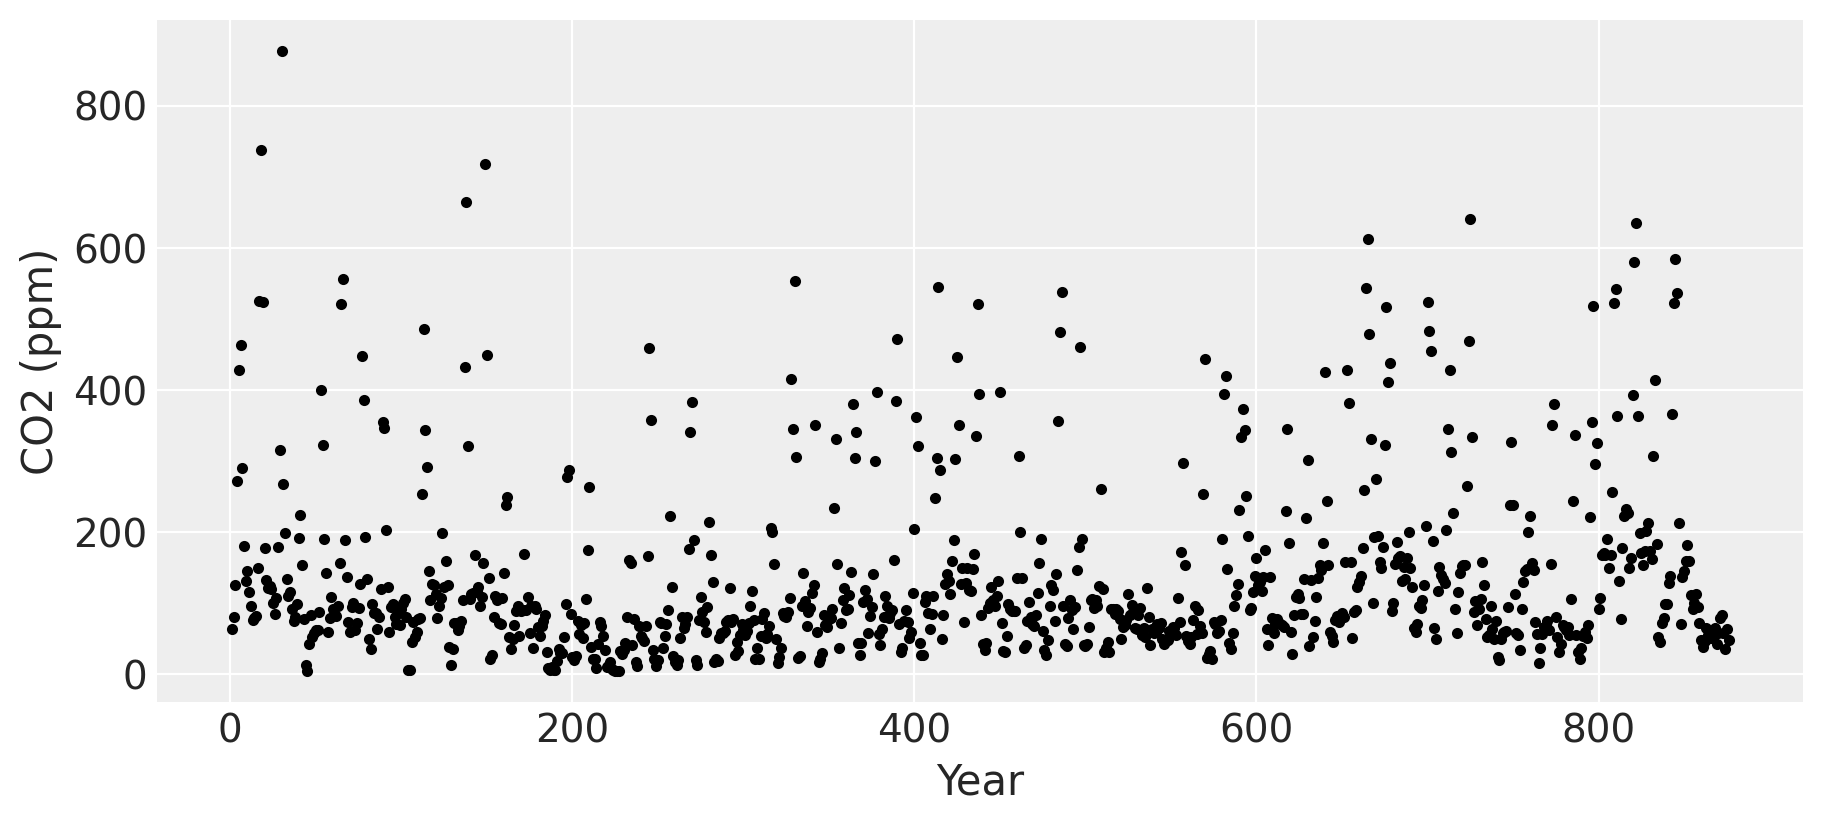

In [8]:
fig = plt.figure(figsize=(9, 4))
ax = plt.gca()

ax.plot(frame.serMonth.values, frame.discharge.values, ".k")
ax.set_xlabel("Year")
ax.set_ylabel("CO2 (ppm)");

Ignore the fact that I labeled my vertical axis wrong, I stole most of this code from the predicting CO2 levels document so I could hack together the boilerplate and then tweak it to fit my model.

The big takeaway here is that theres clearly some global trend and alot of noise I suspect might be monthly as well as a heavy skew

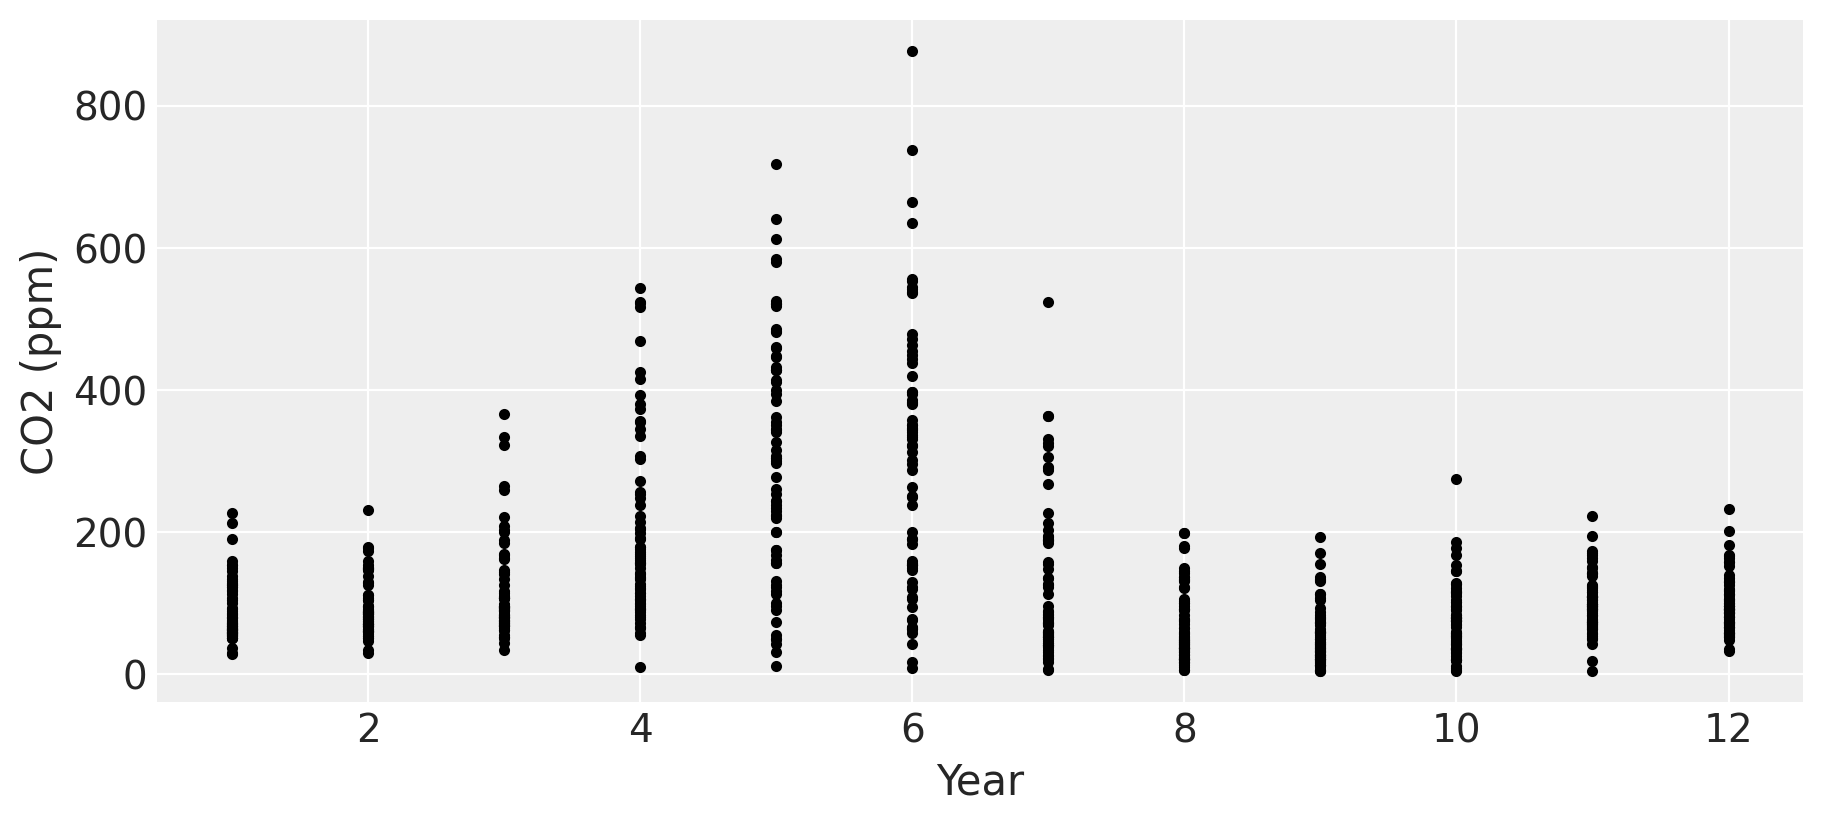

In [9]:
fig = plt.figure(figsize=(9, 4))
ax = plt.gca()

ax.plot(frame.yrMonth.values, frame.discharge.values, ".k")
ax.set_xlabel("Year")
ax.set_ylabel("CO2 (ppm)");

Our monthly trend is made very clear by this. Now sadly as I'll show later I dont understand enough about pymc to sum multiple different kinds of HSGPs like they do in some examples, but theoretically I could try predicitng a global trend and internal trend to get a nice mixture of predictions.

# Atmp 1

Since this model matters the most I'll stick most of my comments here and only note on the subsequent ones the changes I feature.

In [13]:
t = frame.serMonth.values
y = frame.lndis.values

# normalize the discharge readings prior to fitting the model
y_mu, y_sd = np.mean(y[0:50]), np.std(y)
y_n = (y - y_mu) / y_sd

# scale t to have units of years
t_n = t / 12

First I need to extract the variables I want and as per the doc I found nornalize them to make the predictors job a little bit easier.

Now I'll use this kind of scary code below with some funny variables and it just keeps dying. This is because I changed `gp.GP` to `gp.HSGPPeriodic` as it is a significatnly faster proximation and Im scared of training for 12 hours for my model to fail. Turns out you cant use a marginal likelyhood on HSGP's and I still kind of dont know what that means. However, I dont need a marginal likelyhood to figure out if my model is able to model my information well.

In [ ]:
with pm.Model() as model:
    η = pm.HalfNormal("η", sigma=5)
    ℓ = pm.Gamma("ℓ", alpha=4, beta=2)
    α = pm.Gamma("α", alpha=3, beta=1)
    #cov = η**2 * pm.gp.cov.RatQuad(1, α, ℓ)
    #cov = 5*pm.gp.cov.Matern32(1, .5)

    cov_func = pm.gp.cov.Periodic(1, period=1, ls=0.1)

    #gp = pm.gp.HSGP(m = [35]*1, c=4, cov_func=cov)
    gp = pm.gp.HSGPPeriodic(m = 25, scale = 1, cov_func = cov_func)

    # white noise variance
    σ = pm.HalfNormal("σ", sigma=5)
    #y_ = gp.marginal_likelihood("y", X=t_n[:, None], y=y_n, noise=σ)

    tr = pm.sample(target_accept=0.95, return_inferencedata=True)

NotImplementedError: 

In [ ]:
cov.n_dims

1

To do this I just need to give my model a prior variable and then take the conditional using some new points I'll sample in the data and into the future to model a prediction,

In [ ]:
def MapYear(x):
  return 12*(x - 1916)
def DeMapYear(x):
  return x/12 + 1916

In [ ]:
tnew = np.linspace(0, MapYear(2025), 1000) / 12
with model:
    pri = gp.prior("pri", X=tnew[:, None])
    fnew = gp.conditional("fnew", Xnew=tnew[:, None])
    #fnew = gp.conditional("fnew", Xnew=tnew[:, None])

with model:
    ppc = pm.sample_posterior_predictive(tr, var_names=["fnew"])

Output()

And then I can use the plotting function as well as the very pretty pallet I found to see if its working in the slightest

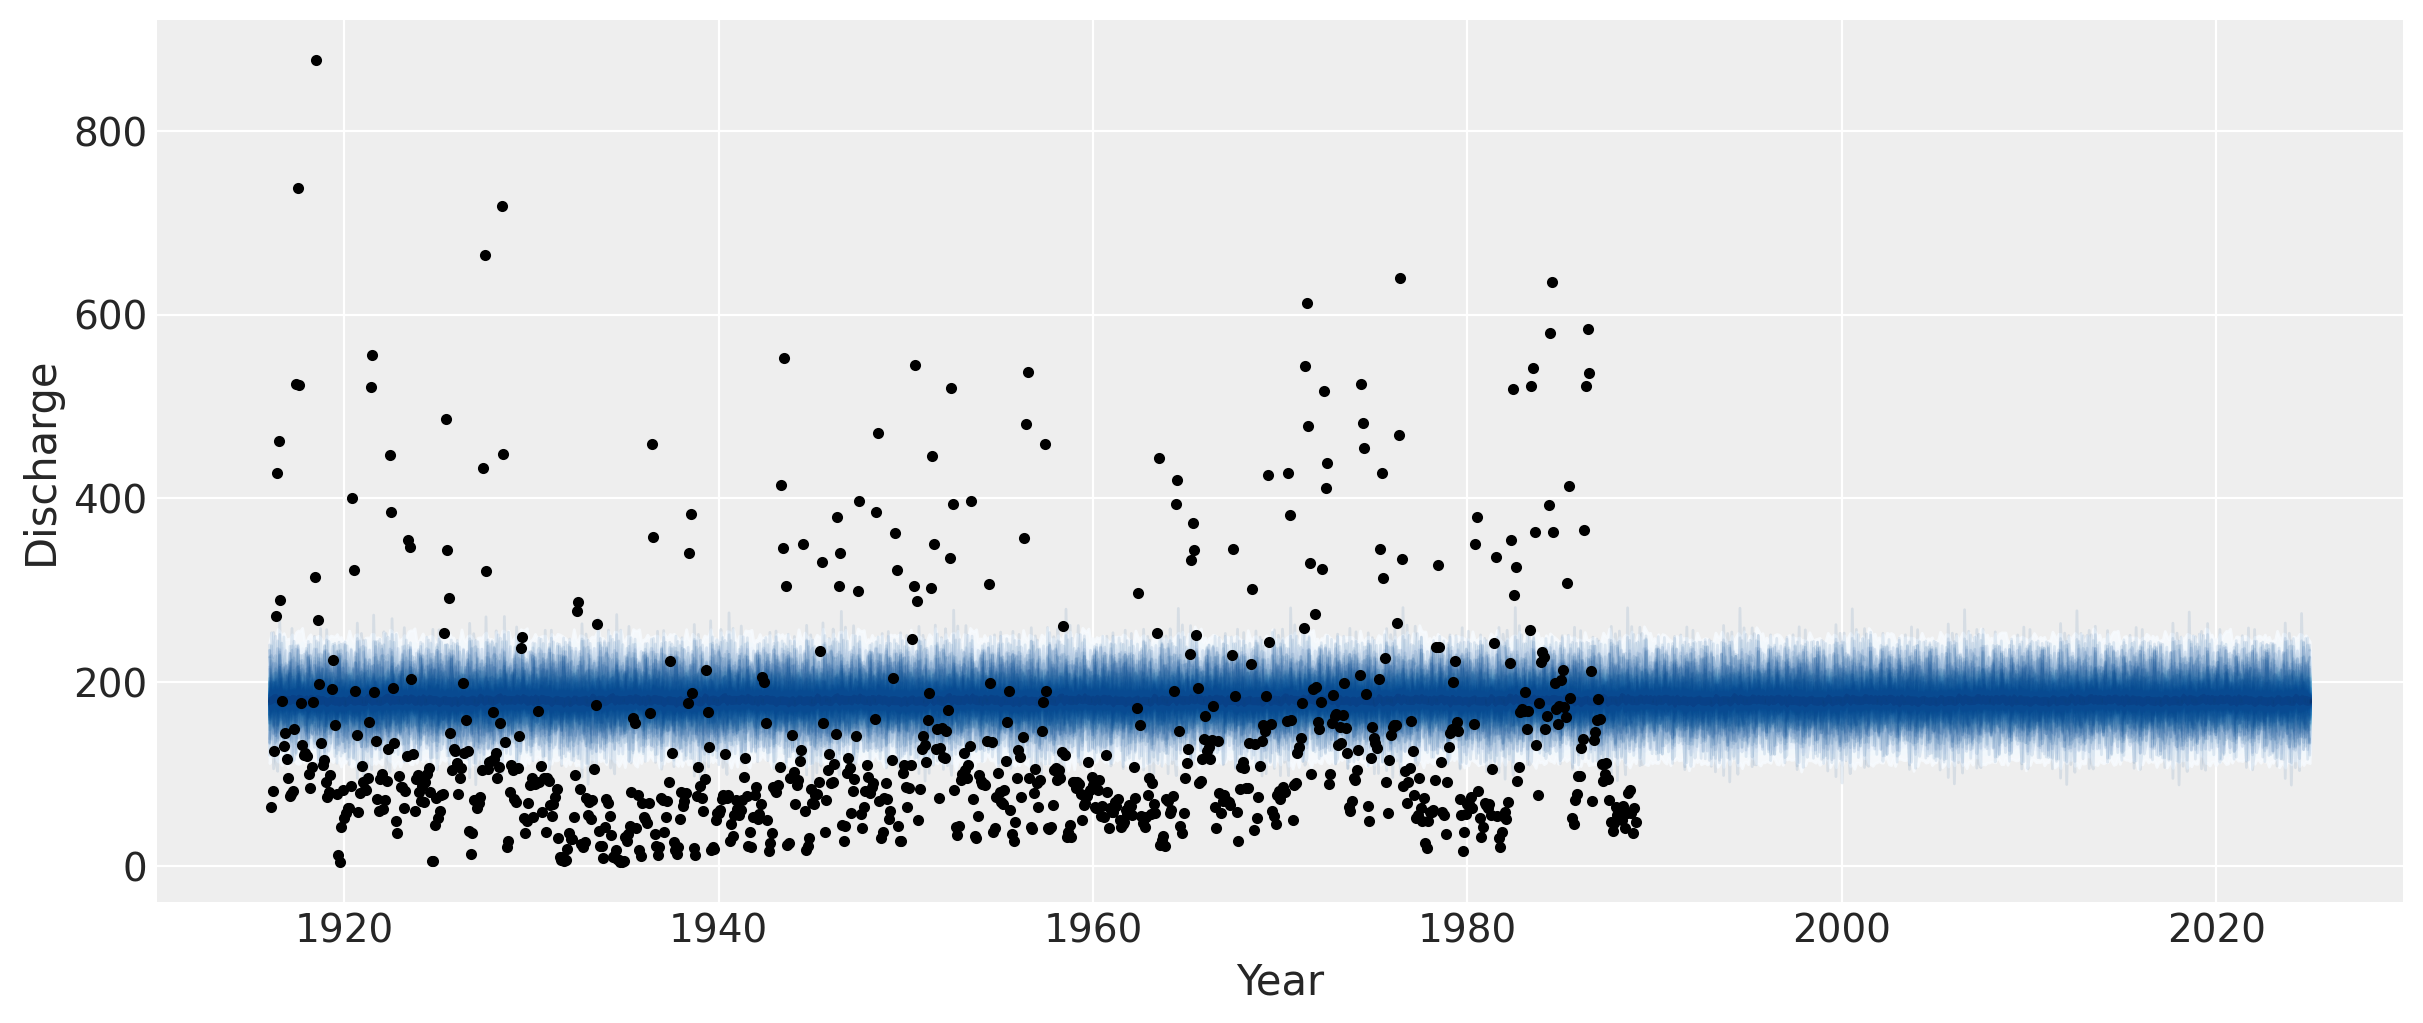

In [ ]:
samples = y_sd * ppc.posterior_predictive["fnew"] + y_mu

fig = plt.figure(figsize=(12, 5))
ax = plt.gca()
pm.gp.util.plot_gp_dist(ax, samples[0, :, :], DeMapYear(12*tnew), plot_samples=True, palette="Blues")
ax.plot(DeMapYear(t), y, "k.")
#ax.set_xlim([-100, 2000])
ax.set_xlim([1910, 2030])
ax.set_ylabel("Discharge")
ax.set_xlabel("Year");

Ok, so clearly my period is way way way too short and so it just spectacularly fails.

# Atmp 2


Little note from the future, this code is from chonologically earlier than makes sense because its onyl used in atmp 3 but I put it here. Thats a minor mistake but I'll explain in time.

In [ ]:
frame['lndis'] = np.log(frame.discharge)

In [ ]:
y = frame.discharge.values
# normalize the discharge readings prior to fitting the model
y_mu, y_sd = np.mean(y[0:50]), np.std(y)
y_n = (y - y_mu) / y_sd

In [ ]:
time_std = np.std(t)

In [ ]:
year = frame.year.values - 1916
serMonth = frame.serMonth.values
yrMonth = frame.yrMonth.values

The below line of code may look random but it matters alot because I was copying some code from predicting baby births which has a similar fractal detail approach and I copied a function for computing a scale parameter which wasnt working. Well turns out it should look like below but it was 10 orders of magnitude large and so the computer cried and just spat out 2000 divergences and gave up.

<Axes: >

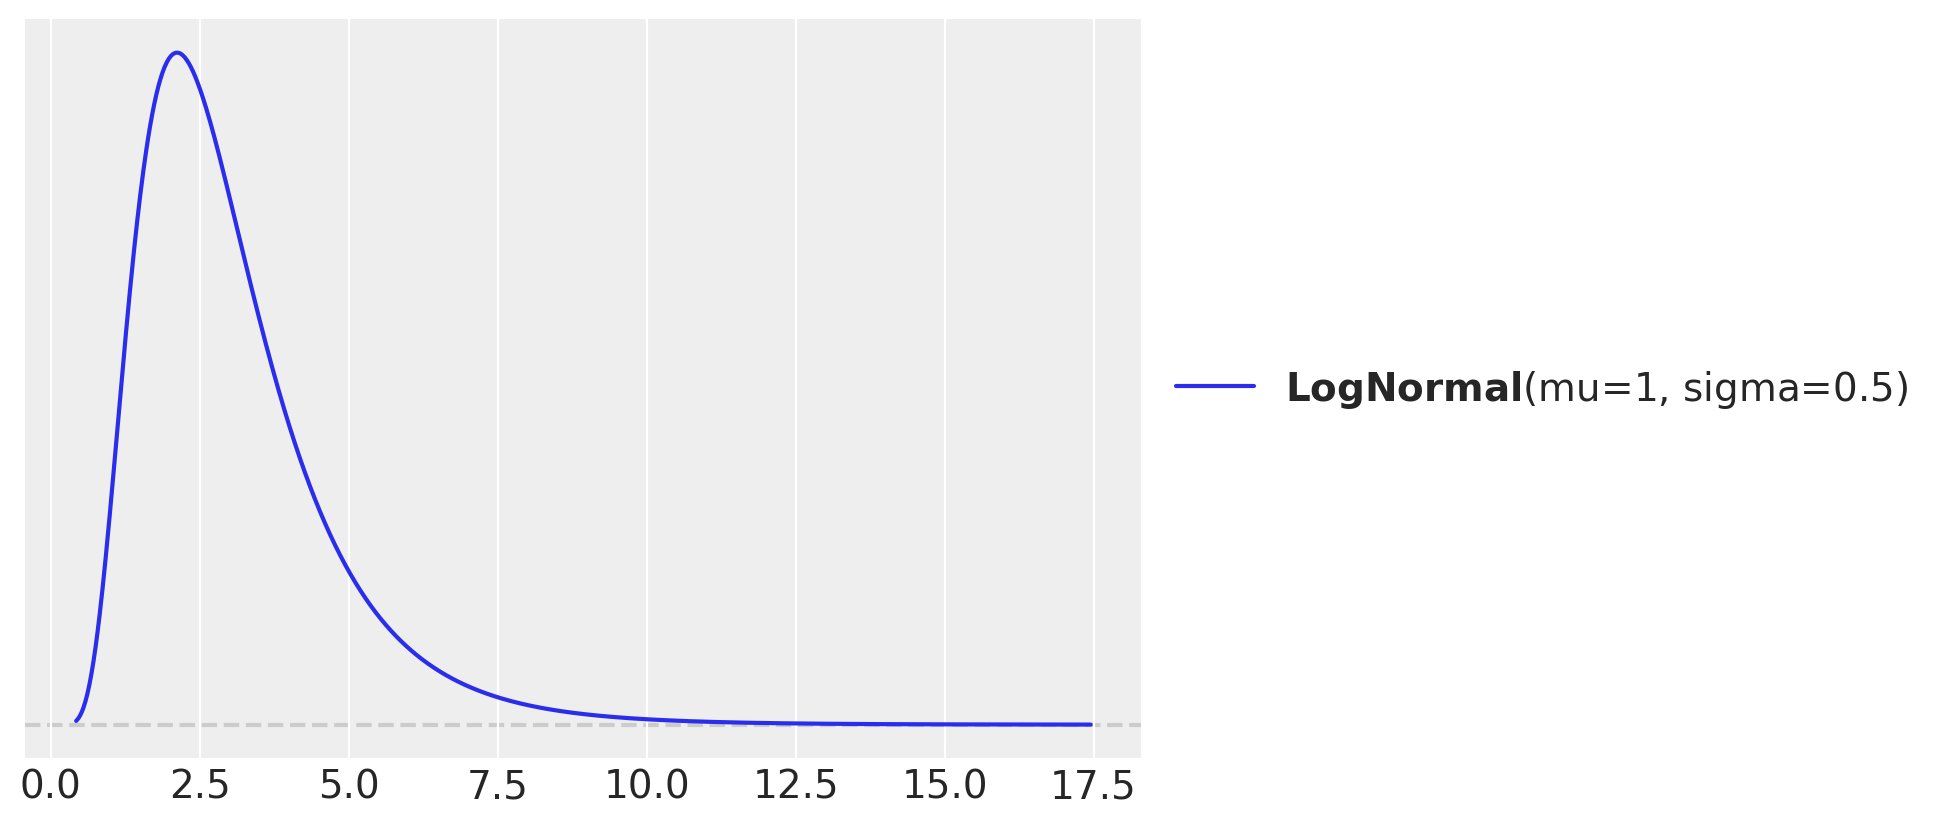

In [ ]:
pz.LogNormal(mu = 1, sigma = .5).plot_pdf()

We want our scale of influence to be local to the neighboring points not global becuase then we wont learn temporal locality.

In [ ]:
coords = {
    "year": year,
    "time": serMonth,
    "month": yrMonth,
}

with pm.Model(coords = coords) as model_2:
    # global trend
    amplitude_trend = pm.HalfNormal(name="amplitude_trend", sigma=1.0)
    ls_trend = pm.LogNormal(name="ls_trend", mu=1, sigma=.5)
    cov_trend = amplitude_trend * pm.gp.cov.ExpQuad(input_dim=1, ls=ls_trend) #ExpQuad is a funny little kernal which just hapens to be support and work well
    gp_trend = pm.gp.HSGP(m=[20], c=1.5, cov_func=cov_trend)
    f_trend = gp_trend.prior(name="f_trend", X=year[:, None], dims="year")  #Not fully sure what this does but its nessisary and I think it trains it or smth

    # --- Parametrization ---
    mu = pm.Deterministic(
        name="mu",
        var=f_trend,
        #+ f_year_periodic
        #+ b_day_of_week[day_of_week_idx_data] * (day_of_week_idx_data > 0),
        dims="year",
    )

    # global noise
    sigma = pm.HalfNormal(name="sigma", sigma=2)

    # --- Likelihood ---
    pm.Normal(
        name="likelihood",
        mu=mu,
        sigma=sigma,
        observed=y_n,
        dims="year",
    )

    tr = pm.sample(target_accept=0.98, return_inferencedata=True)

Output()

Now theoretically, if I actually understood how to display more complex models and reason about them then I could add more things using that deterministic term and such, but as seen below I have to keep it simple or else I get sad.

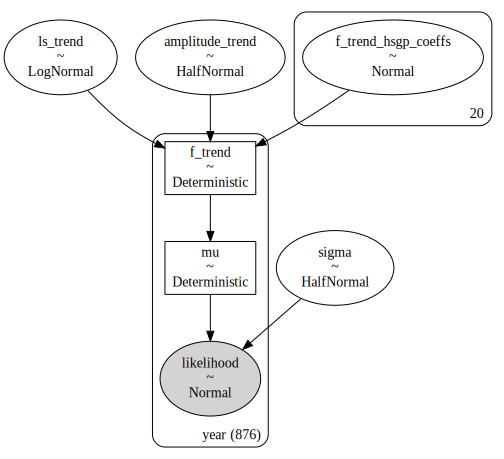

In [ ]:
pm.model_to_graphviz(model=model_2)

In [ ]:
def MapYear(x):
  return (x - 1916)
def DeMapYear(x):
  return x/1 + 1916

In [ ]:
tnew = np.linspace(0, MapYear(2000), 1000)
with model_2:
    fnew = gp_trend.conditional("fnew", Xnew=tnew[:, None])

with model_2:
    ppc = pm.sample_posterior_predictive(tr, var_names=["fnew"])

Output()

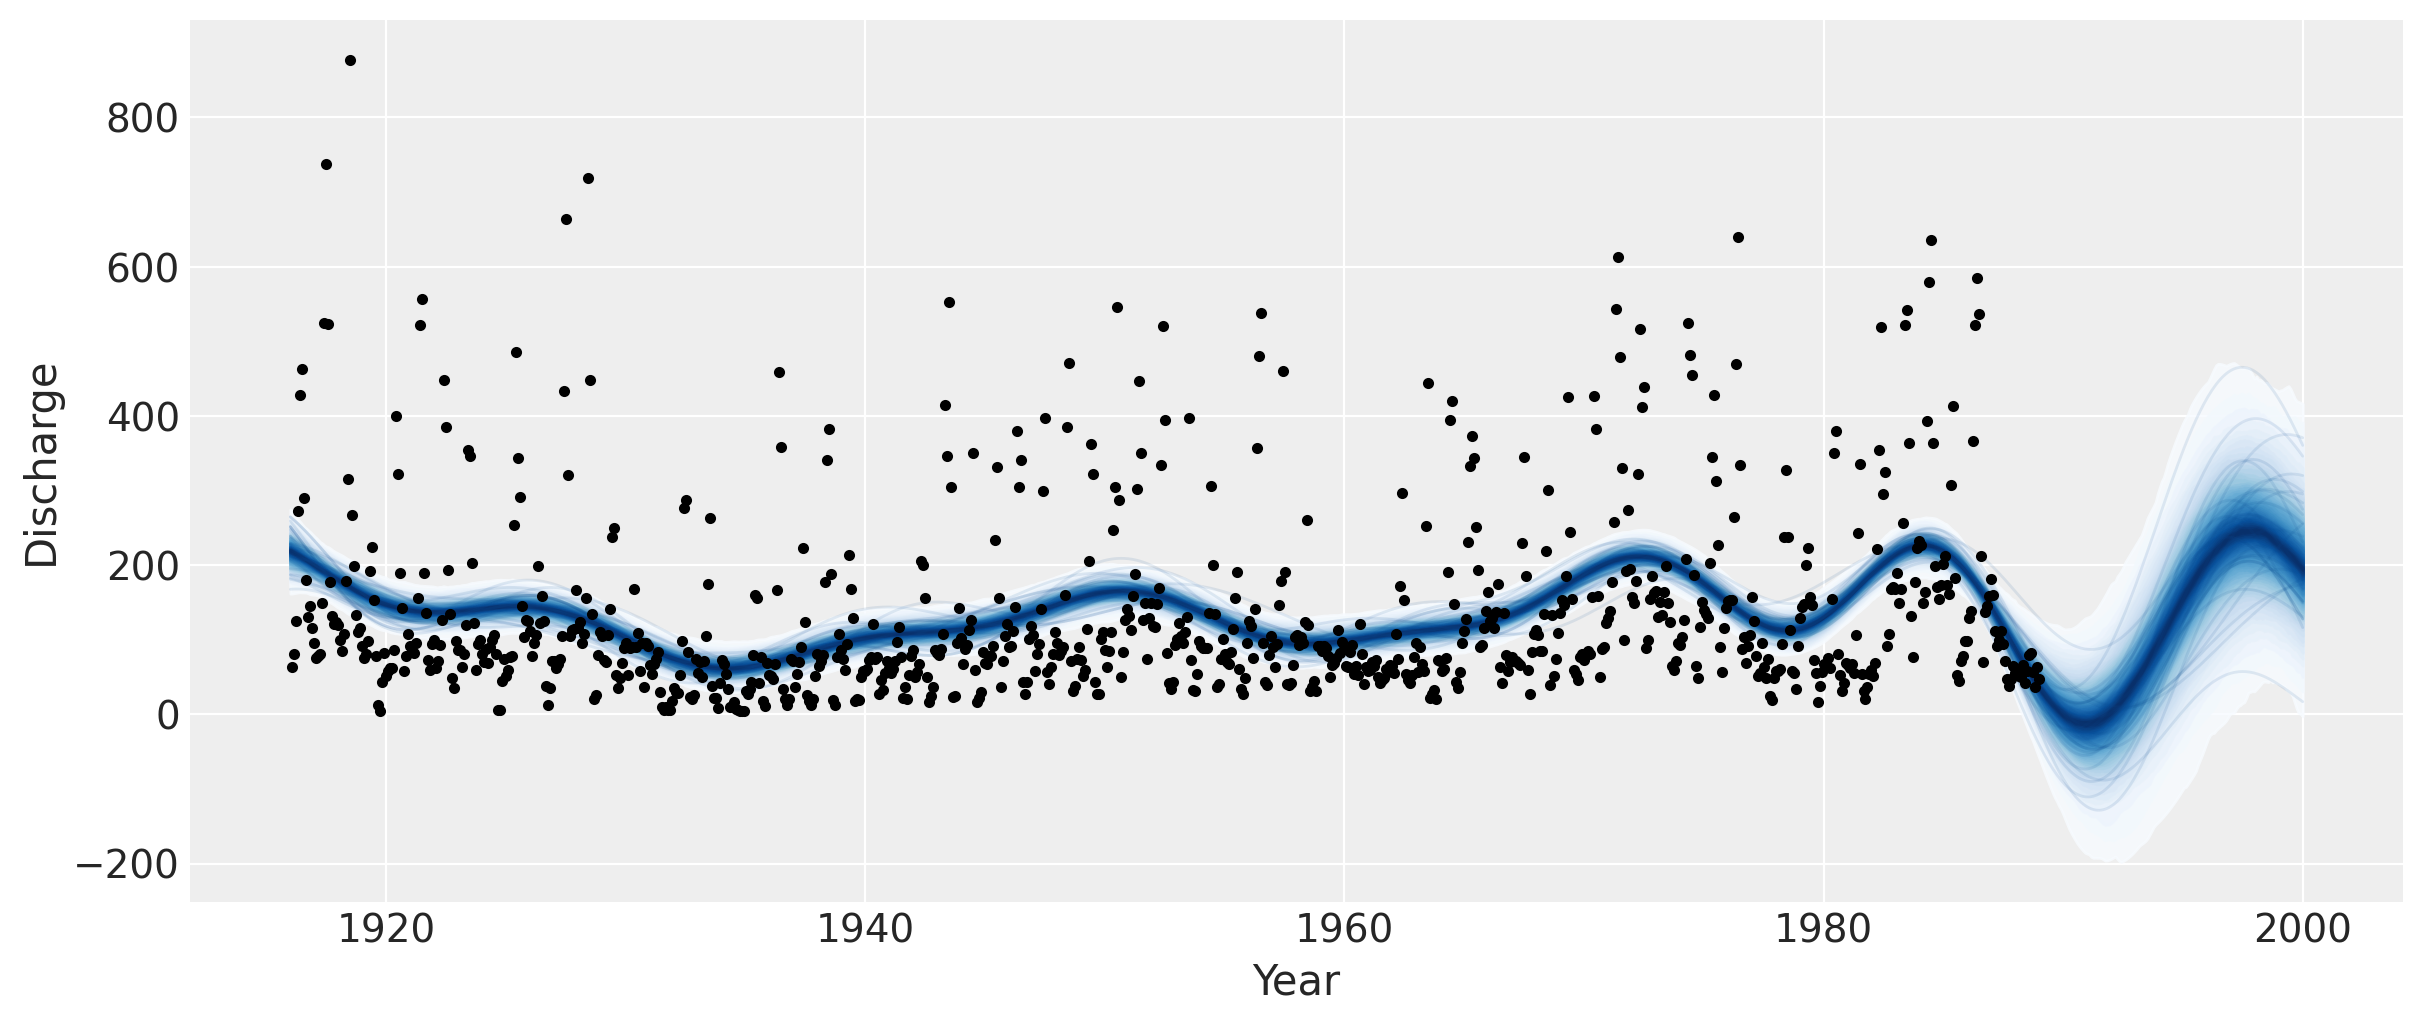

In [ ]:
samples = y_sd * ppc.posterior_predictive["fnew"] + y_mu

fig = plt.figure(figsize=(12, 5))
ax = plt.gca()
pm.gp.util.plot_gp_dist(ax, samples[0, :, :], DeMapYear(1*tnew), plot_samples=True, palette="Blues")
ax.plot((t/12)+1916, y, "k.")
#ax.set_xlim([-100, 2000])
#ax.set_xlim([1910, 2030])
ax.set_ylabel("Discharge")
ax.set_xlabel("Year");

Oh wow, it like, actually works! theres an analysis of the trends and it making predictions.

However I look at it and I see a problem. The prediction line seems to trend too high as its getting dragged up by the season highs. Additionally our model doesnt know that negative predictions dont make sense so it thinks following what we observed we should have a large plummet into negatives. We can fix this using our logarithm discharge which doesnt go negative and accounts for skew

array([[<Axes: title={'center': 'discharge'}>]], dtype=object)

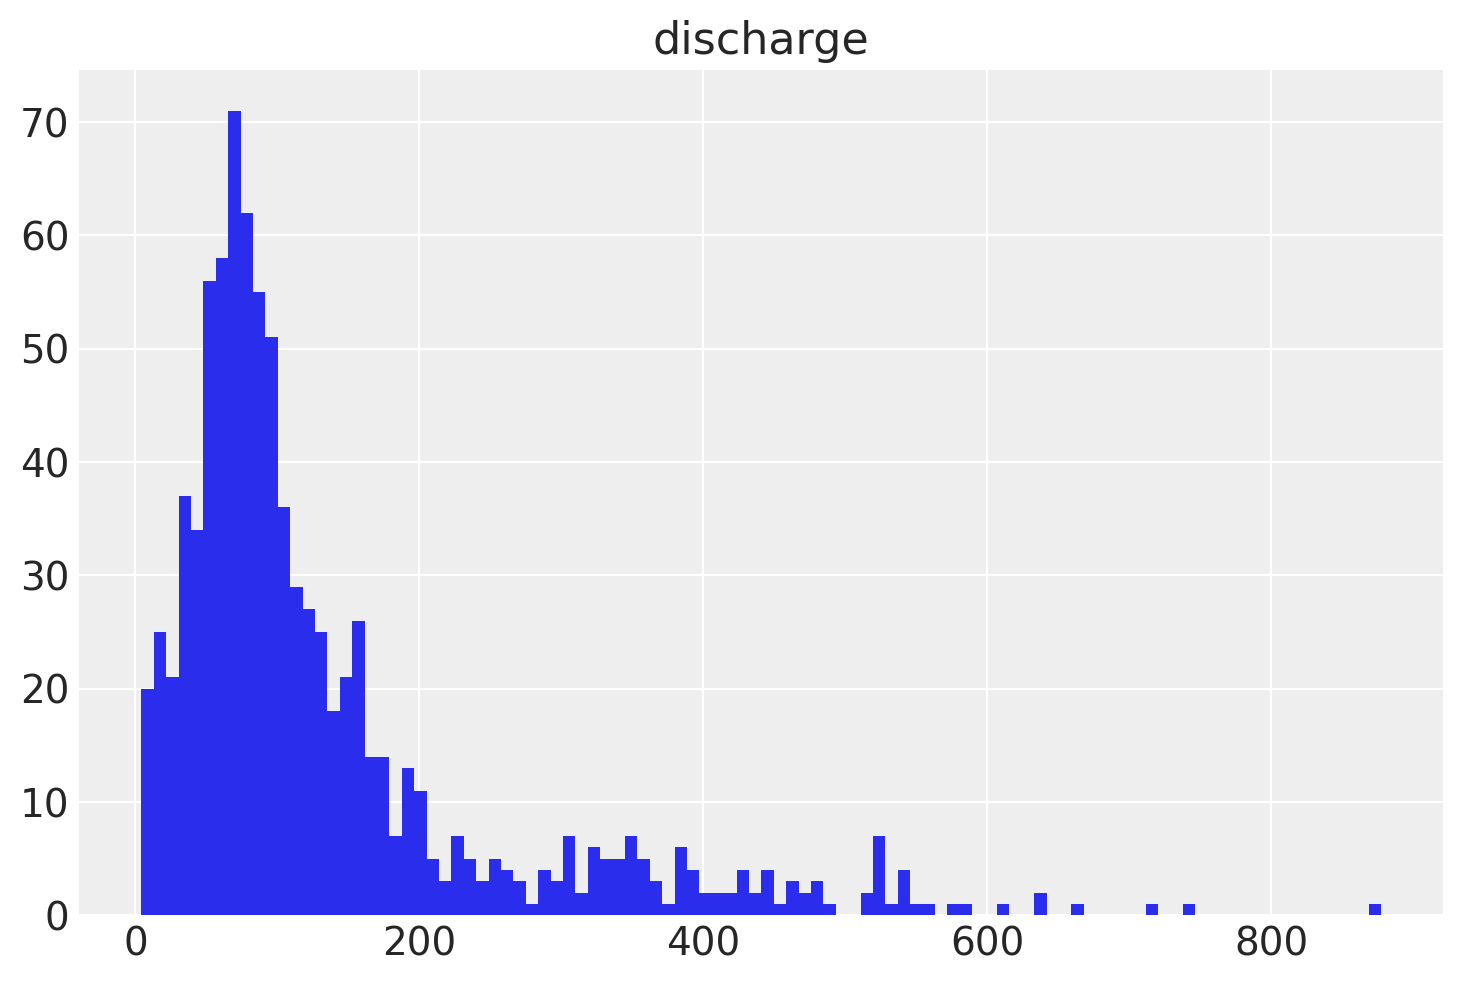

In [36]:
frame.hist("discharge", bins = 100)

array([[<Axes: title={'center': 'lndis'}>]], dtype=object)

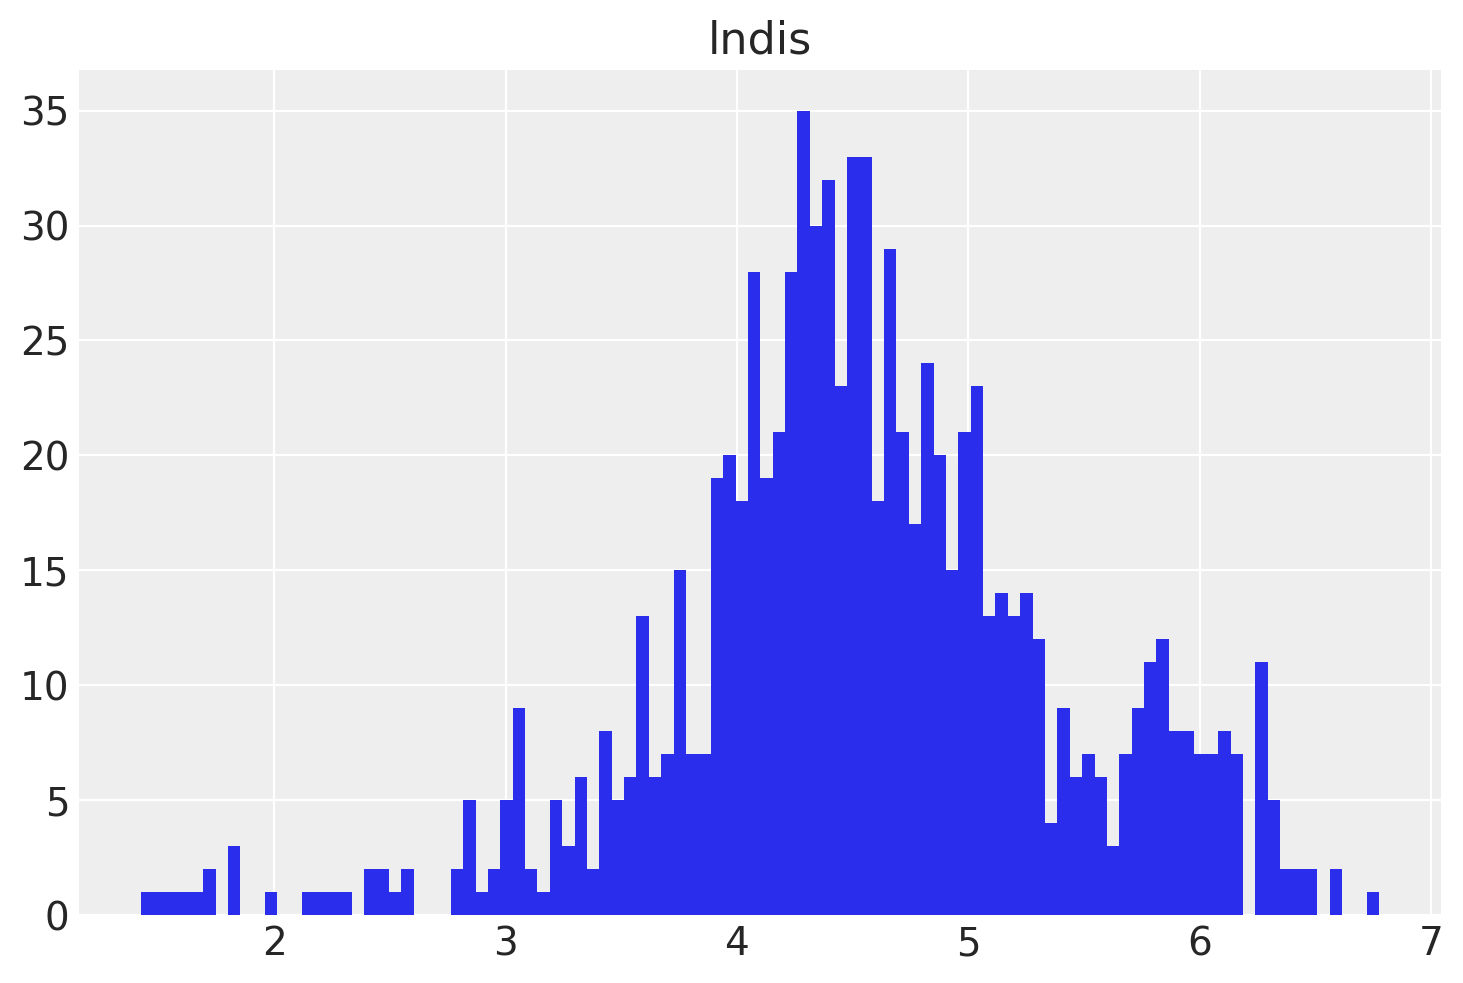

In [ ]:
frame.hist("lndis", bins = 100)

As we can see, its not perfect but this data is far far more normal looking than before

# Atmp 3


Ok so that piece of code I put here again just so I can run it indepenetly but Imma use the logarithm of discharge to encode knowledge I know about our prediction.

Otherwise tho, our code will be by and large the same as the parameters I tweaked worked. I didnt show them but it was mostly just tweaking until it straight up ran, so having a bunch of errors felt wierd and I cleaned it up.

In [ ]:
frame['lndis'] = np.log(frame.discharge)

In [ ]:
y = frame.lndis.values
# normalize the discharge readings prior to fitting the model
y_mu, y_sd = np.mean(y[0:50]), np.std(y)
y_n = (y - y_mu) / y_sd

In [ ]:
time_std = np.std(t)

In [ ]:
year = frame.year.values - 1916
serMonth = frame.serMonth.values
yrMonth = frame.yrMonth.values

<Axes: >

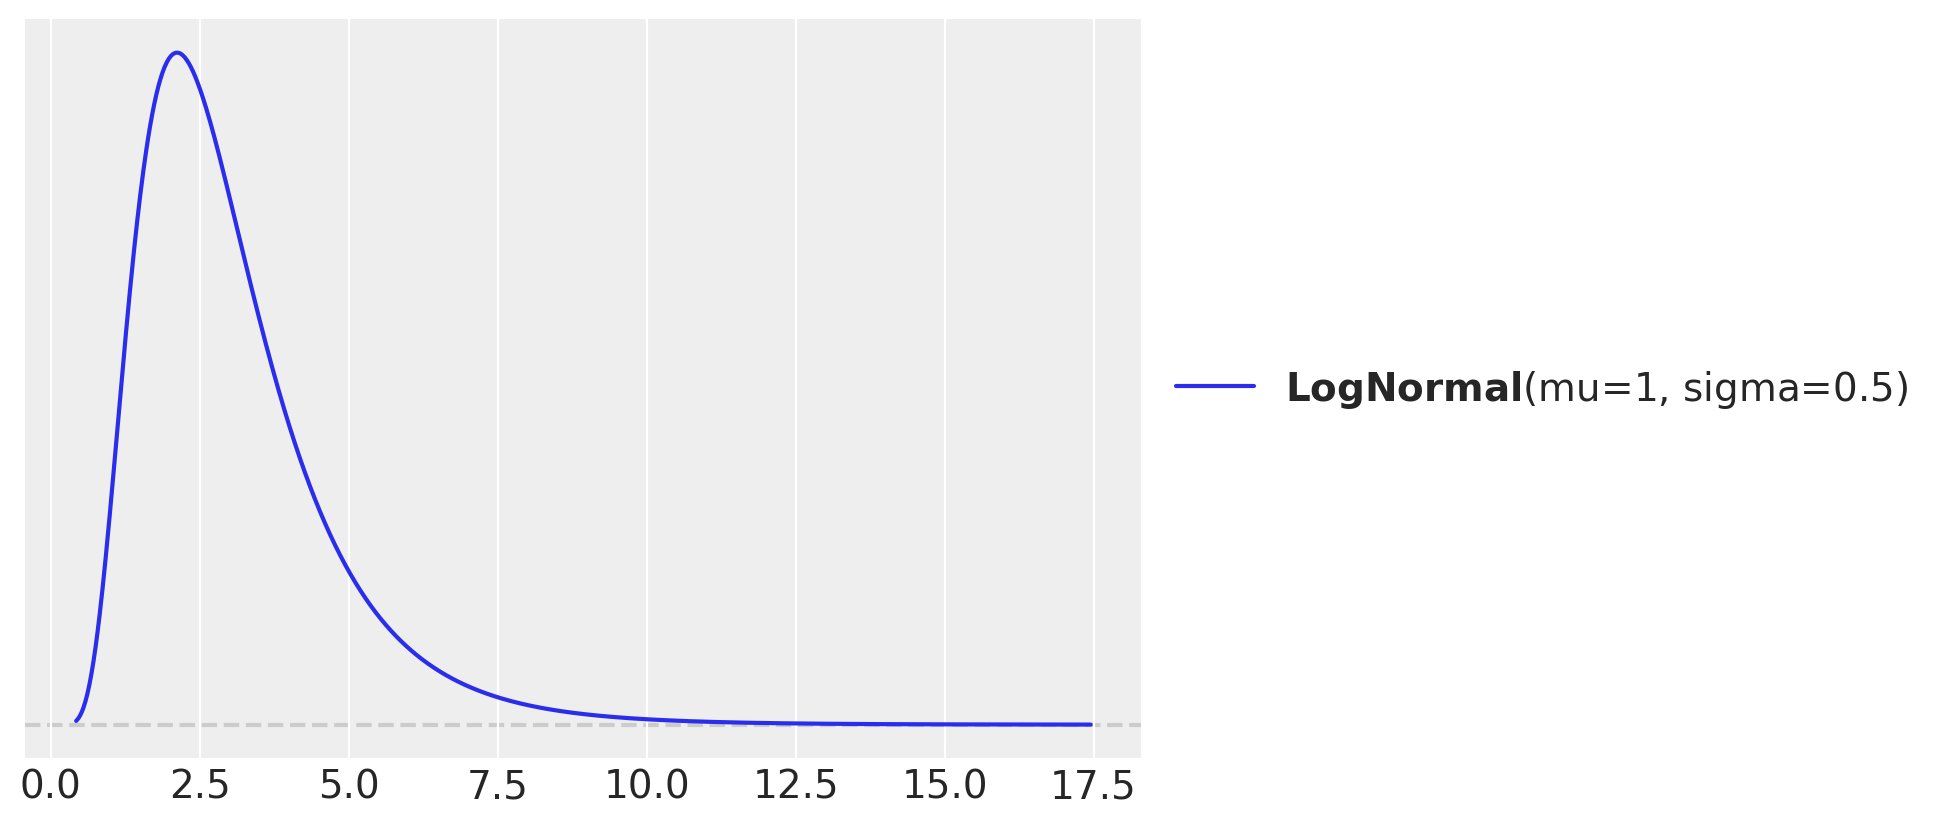

In [ ]:
pz.LogNormal(mu = 1, sigma = .5).plot_pdf()

In [ ]:
coords = {
    "year": year,
    "time": serMonth,
    "month": yrMonth,
}

with pm.Model(coords = coords) as model_3:
    # global trend
    amplitude_trend = pm.HalfNormal(name="amplitude_trend", sigma=1.0)
    ls_trend = pm.LogNormal(name="ls_trend", mu=1, sigma=.5)
    cov_trend = amplitude_trend * pm.gp.cov.ExpQuad(input_dim=1, ls=ls_trend)
    gp_trend = pm.gp.HSGP(m=[20], c=1.5, cov_func=cov_trend)
    f_trend = gp_trend.prior(name="f_trend", X=year[:, None], dims="year")

    # --- Parametrization ---
    mu = pm.Deterministic(
        name="mu",
        var=f_trend,
        #+ f_year_periodic
        #+ b_day_of_week[day_of_week_idx_data] * (day_of_week_idx_data > 0),
        dims="year",
    )

    # global noise
    sigma = pm.HalfNormal(name="sigma", sigma=2)

    # --- Likelihood ---
    pm.Normal(
        name="likelihood",
        mu=mu,
        sigma=sigma,
        observed=y_n,
        dims="year",
    )

    tr = pm.sample(target_accept=0.98, return_inferencedata=True)

Output()

In [ ]:
def MapYear(x):
  return (x - 1916)
def DeMapYear(x):
  return x/1 + 1916

In [ ]:
tnew = np.linspace(0, MapYear(2000), 1000)
with model_3:
    #pri = gp_trend.prior("pri", X=tnew[:, None])
    fnew = gp_trend.conditional("fnew", Xnew=tnew[:, None])

with model_3:
    ppc = pm.sample_posterior_predictive(tr, var_names=["fnew"])

Output()

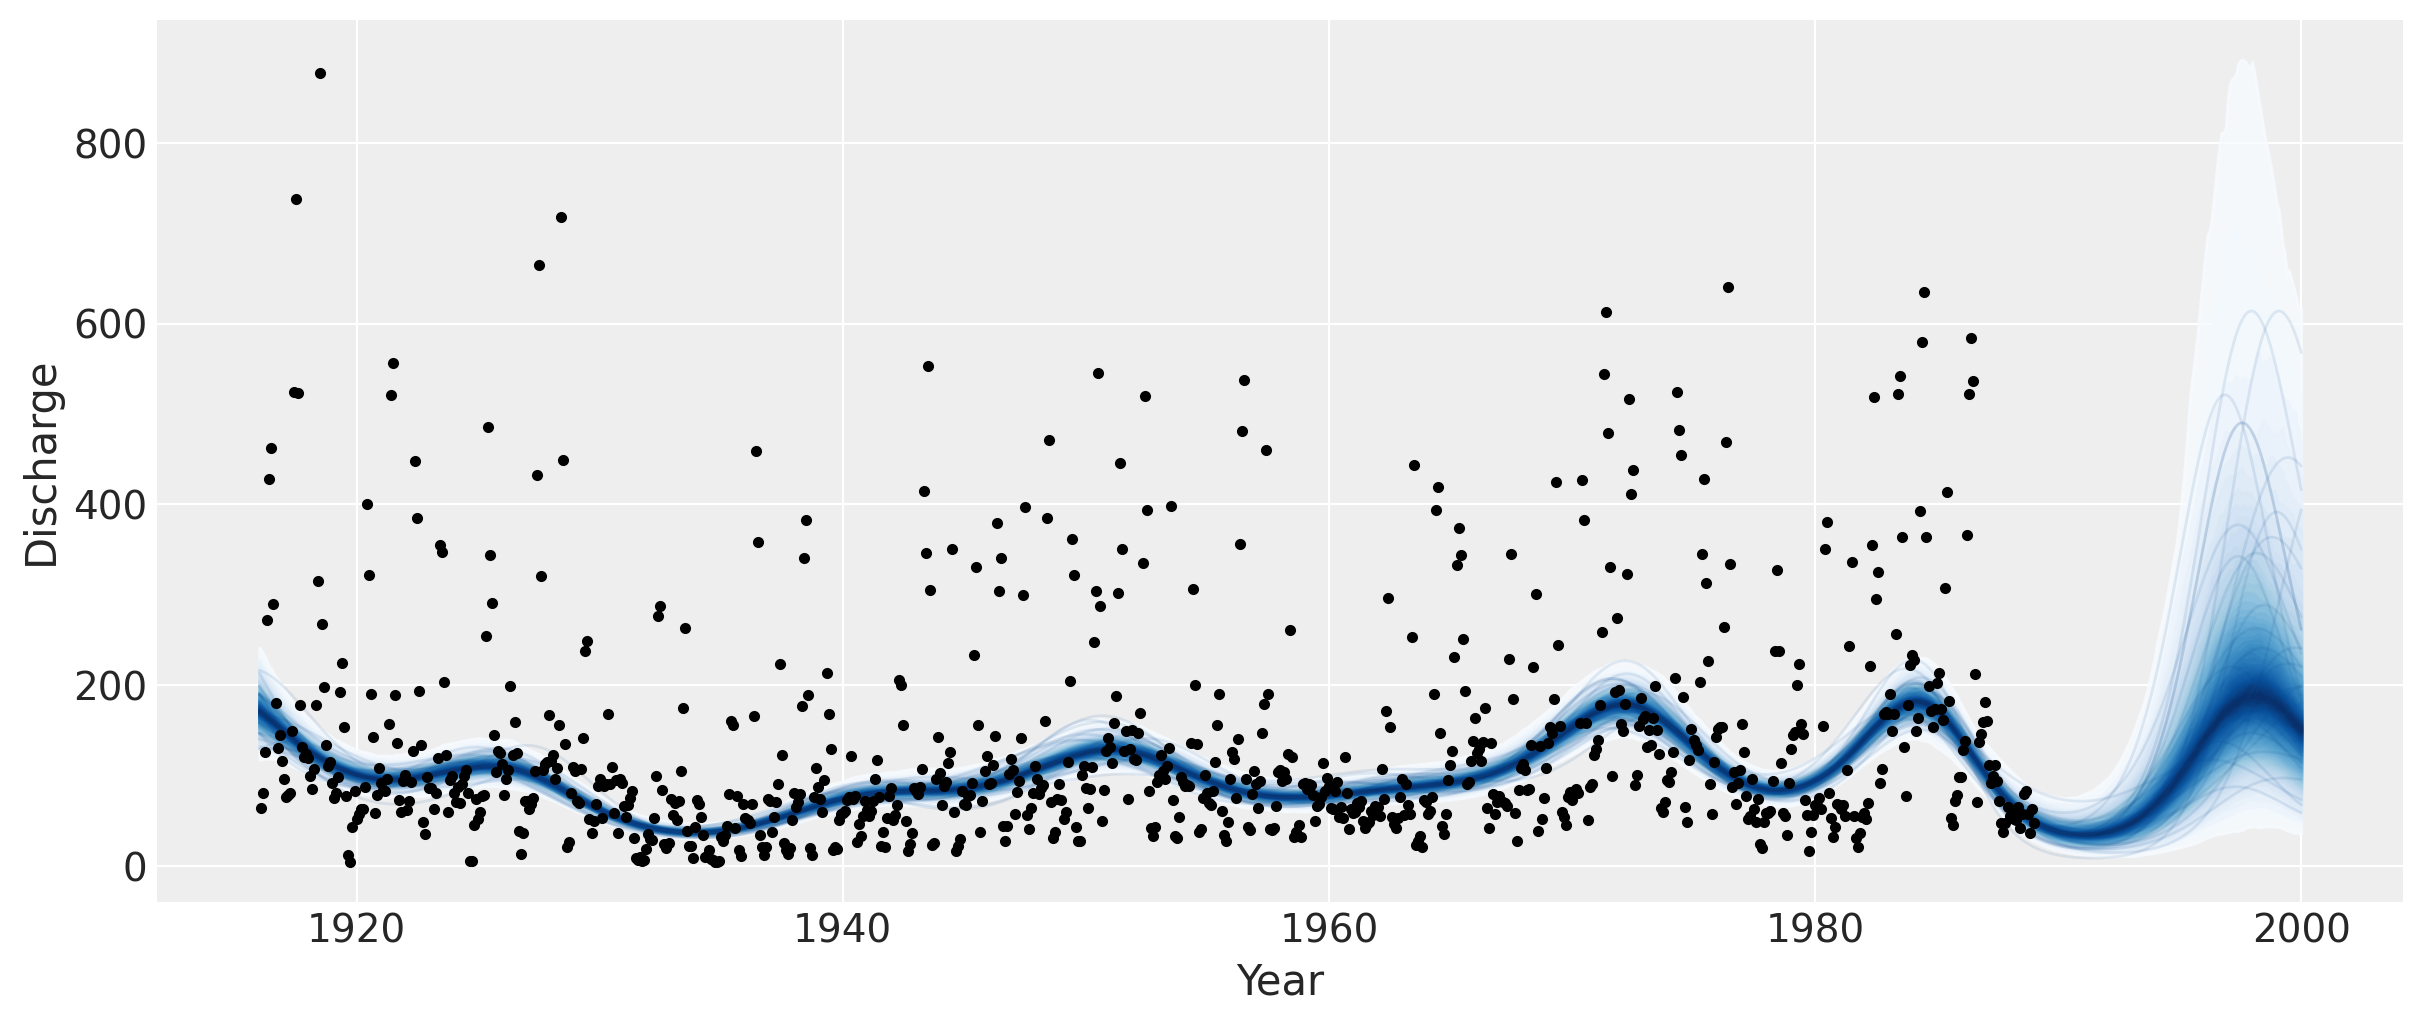

In [ ]:
samples = np.exp(y_sd * ppc.posterior_predictive["fnew"] + y_mu)

fig = plt.figure(figsize=(12, 5))
ax = plt.gca()
pm.gp.util.plot_gp_dist(ax, samples[0, :, :], DeMapYear(1*tnew), plot_samples=True, palette="Blues")
ax.plot((t/12)+1916, np.exp(y), "k.")
#ax.set_xlim([-100, 2000])
#ax.set_xlim([1910, 2030])
ax.set_ylabel("Discharge")
ax.set_xlabel("Year");

This is gonna be where I put more of my commentary than last time, mostly in that as we can see, our trendline now sits more with the median than the mean which Id consider a success.

Additionally it no longer predicts a negative discharge, but a record low and then what might be a normal season or potentially a massive flood event in 2000.

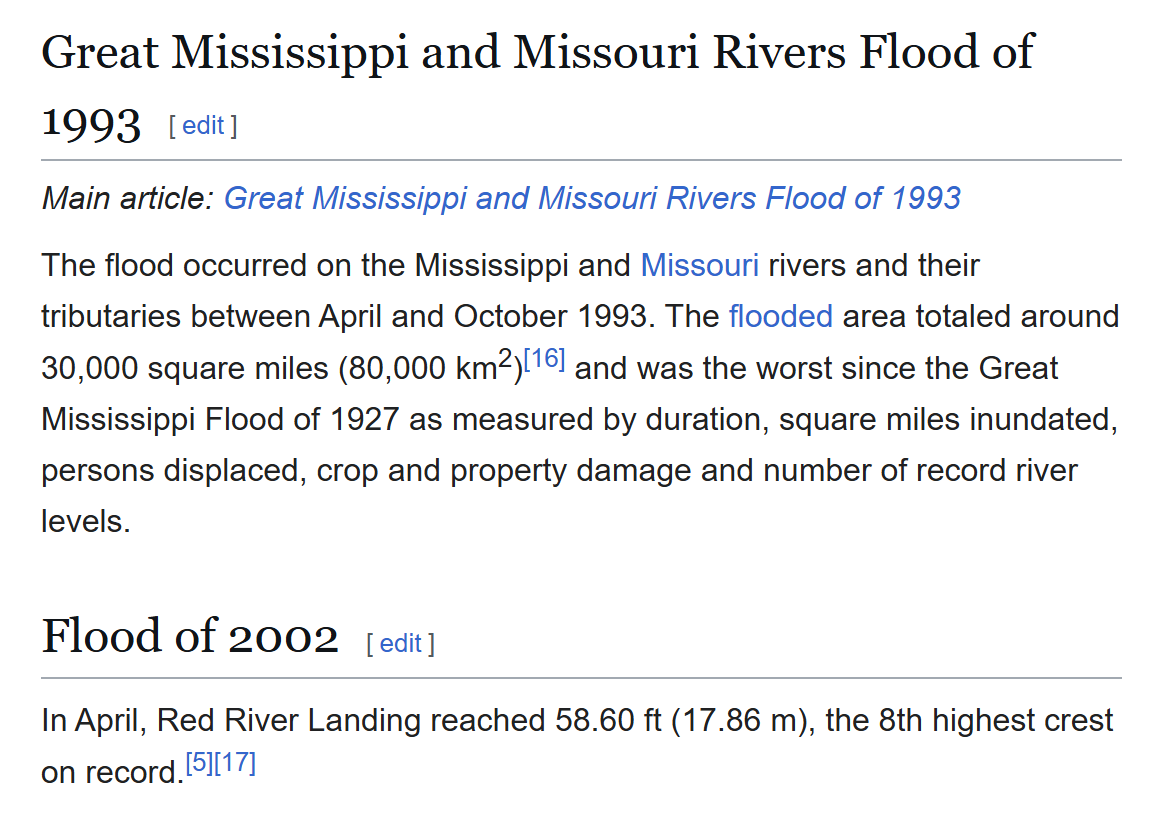

Hey, what do you know, there were 2 large floods around then. Idk if this means my model works but it makes me happy for sure that it seems like it is.

# Atmp 4 (Failed)

A heads up, this code was a complete failure because even tho the docs say you can add HSGP kernals together, if I try to down below it says thats not supported which makes me feel like it was either deprecated or refering to something else.

In [14]:
frame['lndis'] = np.log(frame.discharge)

In [15]:
y = frame.lndis.values
# normalize the discharge readings prior to fitting the model
y_mu, y_sd = np.mean(y[0:50]), np.std(y)
y_n = (y - y_mu) / y_sd

In [16]:
time_std = np.std(t)

In [17]:
year = frame.year.values - 1916
serMonth = frame.serMonth.values
yrMonth = frame.yrMonth.values

<Axes: >

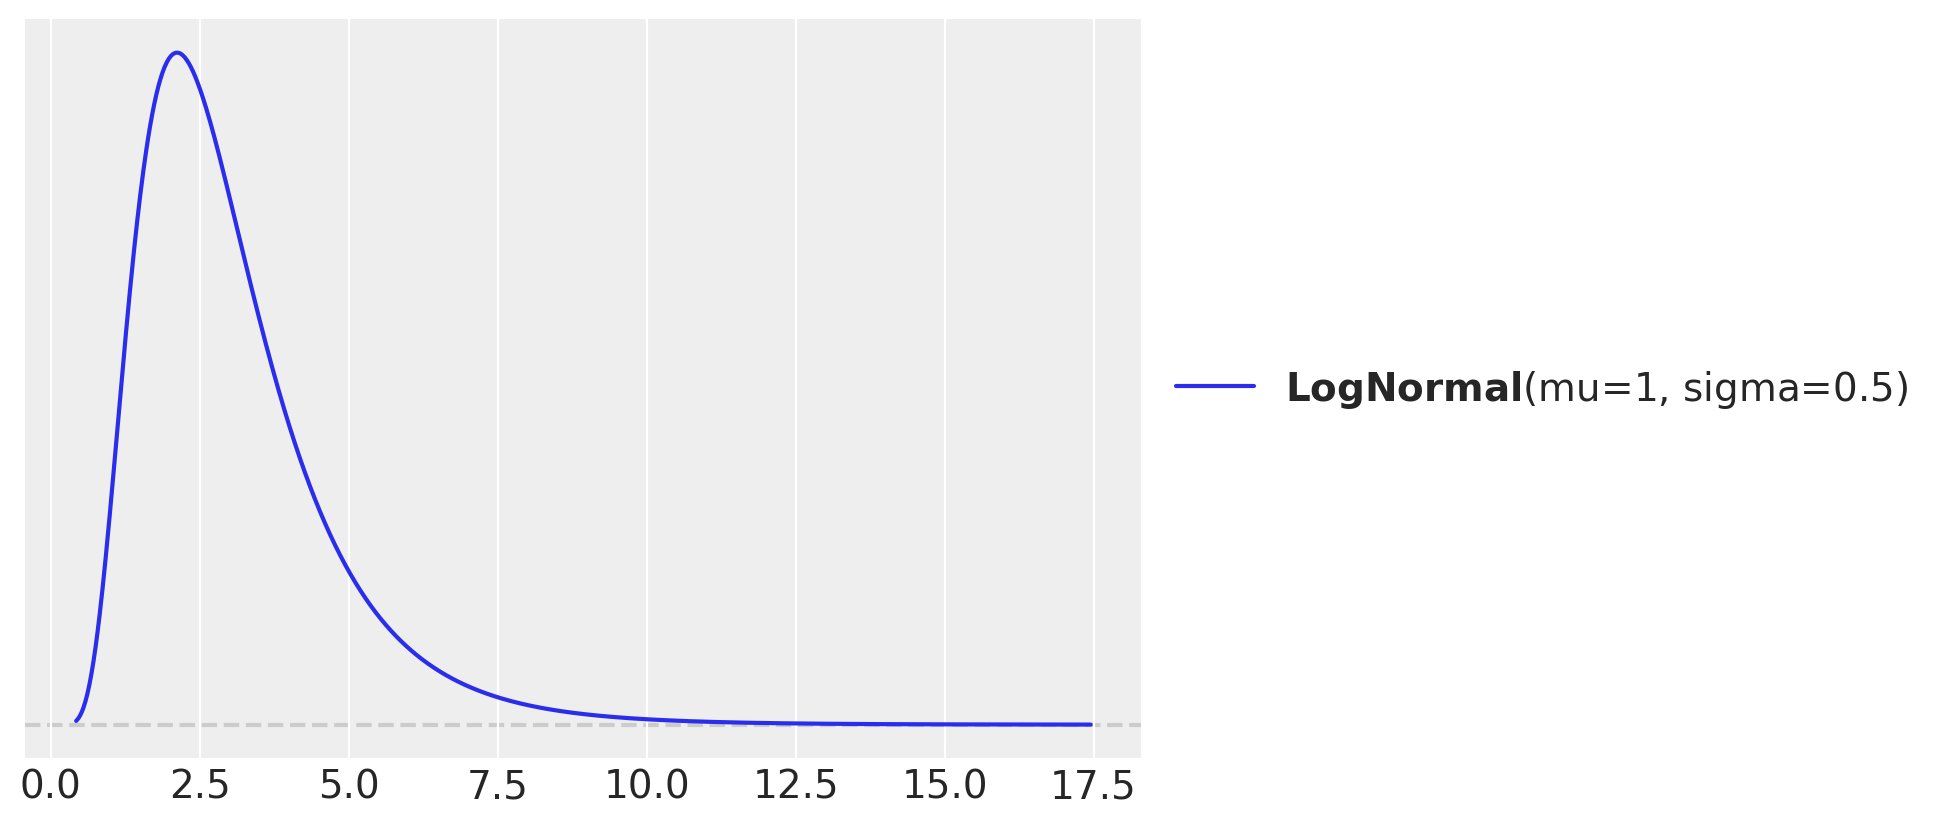

In [18]:
pz.LogNormal(mu = 1, sigma = .5).plot_pdf()

In [20]:
coords = {
    "year": year,
    "time": serMonth,
    "month": yrMonth,
}

with pm.Model(coords = coords) as model_5:
    # global trend
    amplitude_trend = pm.HalfNormal(name="amplitude_trend", sigma=1.0)
    ls_trend = pm.LogNormal(name="ls_trend", mu=1, sigma=.5) / 4
    cov_trend = amplitude_trend * pm.gp.cov.ExpQuad(input_dim=1, ls=ls_trend)
    gp_trend = pm.gp.HSGP(m=[20], c=1.5, cov_func=cov_trend)

    gp_total = gp_trend

    f_trend = gp_total.prior(name="f_trend", X=year[:, None], dims="time")

    tr = pm.sample(target_accept=0.98, return_inferencedata=True)

Output()

In [21]:
def MapYear(x):
  return (x - 1916)
def DeMapYear(x):
  return x/1 + 1916

In [22]:
tnew = np.linspace(0, MapYear(2000), 1000)
with model_5:
    #pri = gp_trend.prior("pri", X=tnew[:, None])
    fnew = gp_trend.conditional("fnew", Xnew=tnew[:, None])

with model_5:
    ppc = pm.sample_posterior_predictive(tr, var_names=["fnew"])

Output()

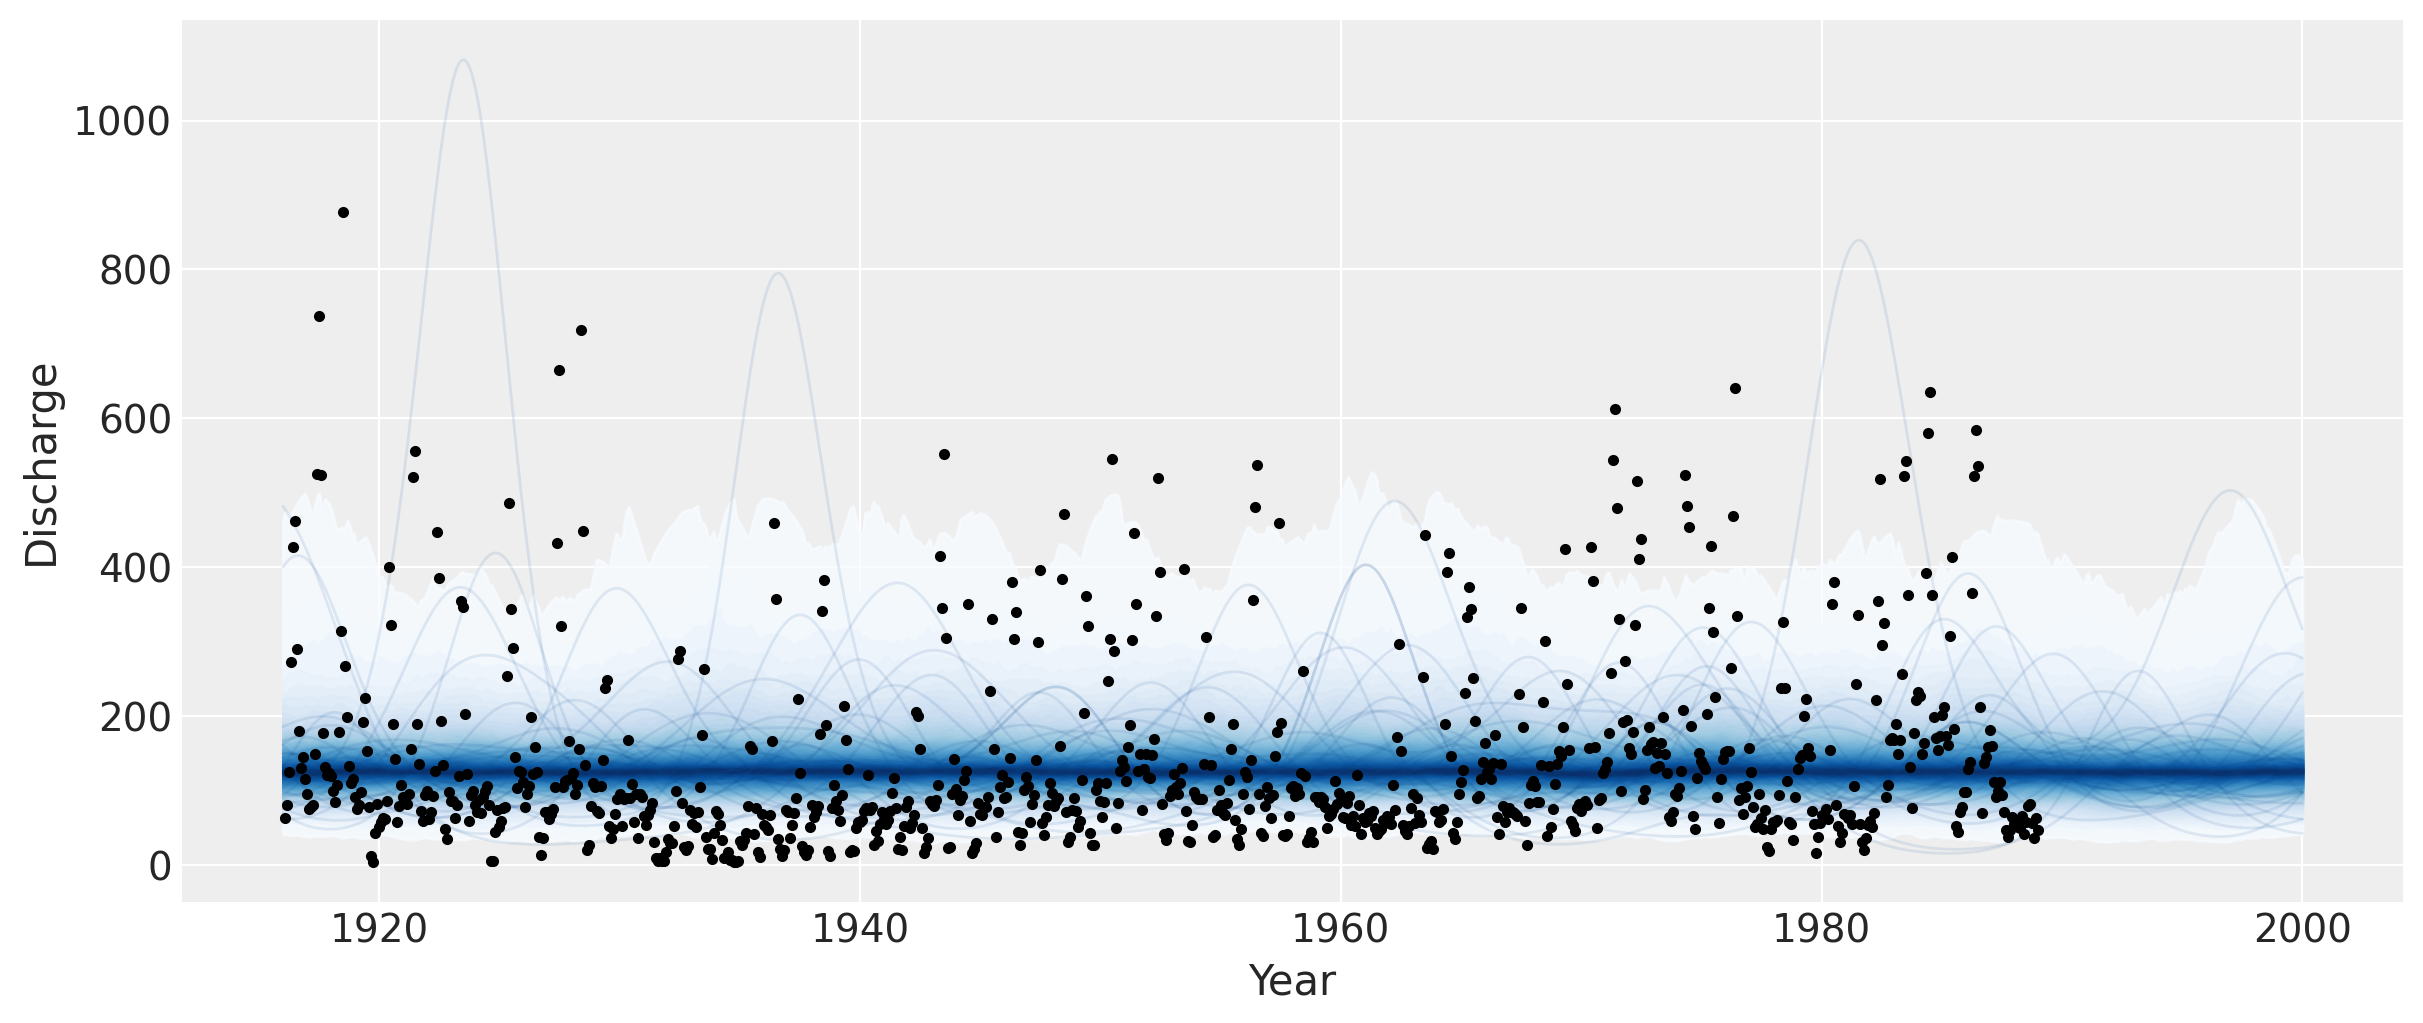

In [23]:
samples = np.exp(y_sd * ppc.posterior_predictive["fnew"] + y_mu)

fig = plt.figure(figsize=(12, 5))
ax = plt.gca()
pm.gp.util.plot_gp_dist(ax, samples[0, :, :], DeMapYear(1*tnew), plot_samples=True, palette="Blues")
ax.plot((t/12)+1916, np.exp(y), "k.")
#ax.set_xlim([-100, 2000])
#ax.set_xlim([1910, 2030])
ax.set_ylabel("Discharge")
ax.set_xlabel("Year");

In [24]:
with model_5:
    idata = pm.sample(target_accept=0.9,)
    pm.sample_posterior_predictive(trace=idata, extend_inferencedata=True, return_inferencedata=False)

Output()

In [25]:
idata

Inference data with groups:
	> posterior
	> sample_stats

In [35]:
idata.posterior_predictive = idata.posterior
idata.observed_data =

AttributeError: 'InferenceData' object has no attribute 'observed_data'

AttributeError: 'InferenceData' object has no attribute 'data_vars'

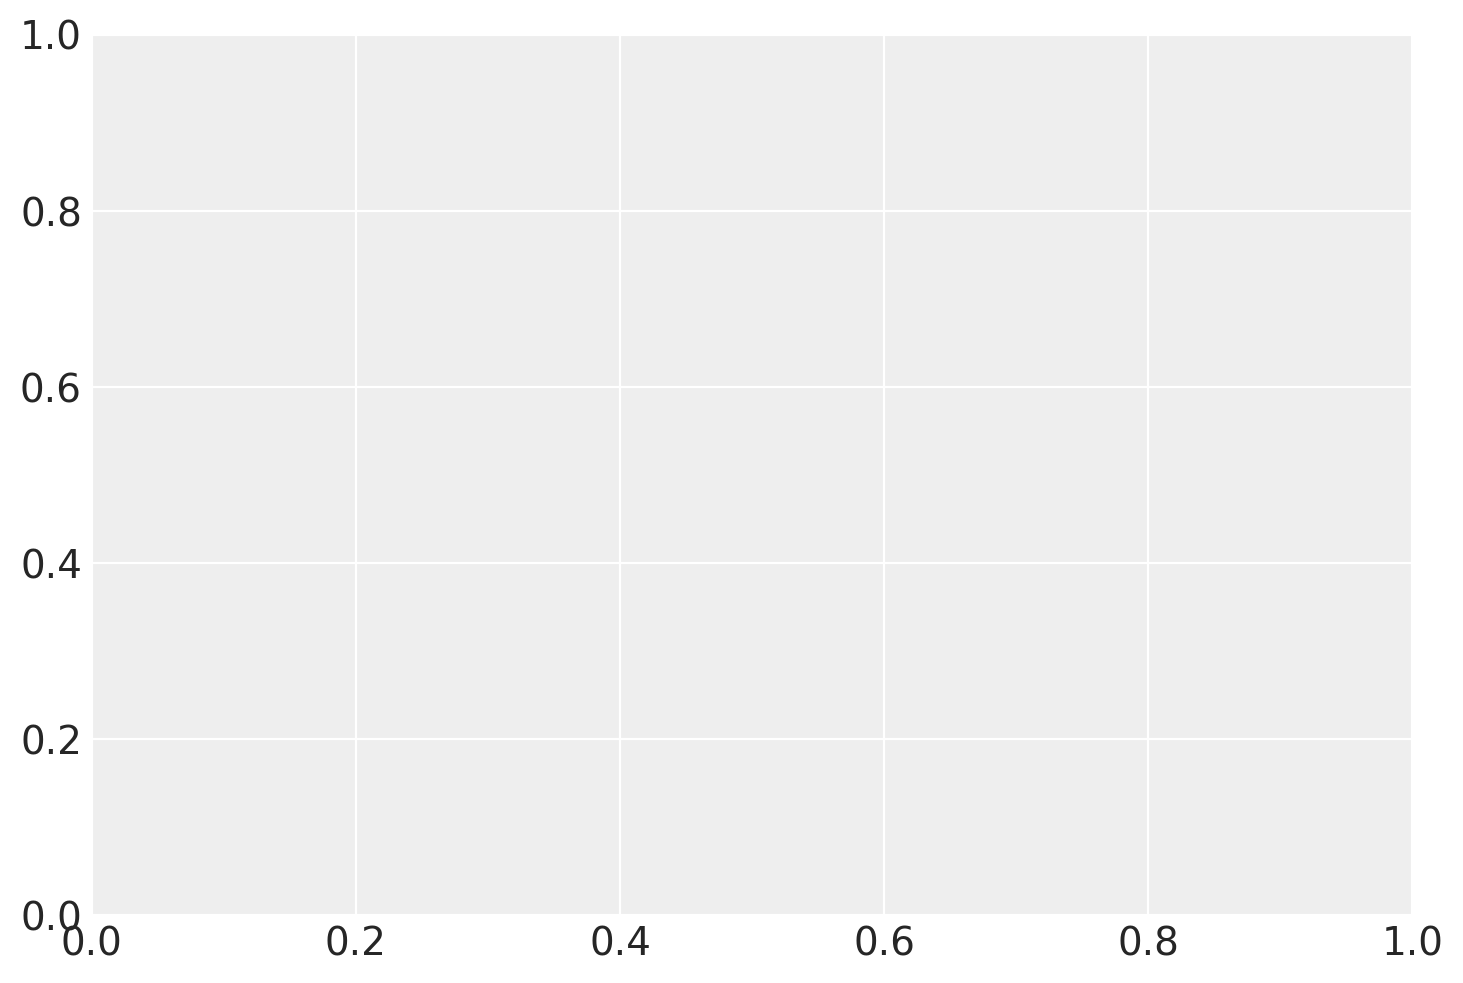

In [34]:
fig, ax = plt.subplots()
az.plot_ppc(
    data=idata,
    num_pp_samples=1_000,
    observed_rug=True,
    ax=ax,
)
ax.set_title(label="Posterior Predictive", fontsize=18, fontweight="bold");

# Conclusion

GP's are very power devices for prediction but as they get more powerful they get kind of hard to understand and prepare. At least for me, its very hard to reason about what prior variables work well for my model and if you screw them up your model might die with no explanation.

All that said, an HSGP works very well for my data which is very simple and temporal and yet gave a nice result. I know they can do even better so clearly theyre good but a simple one is approachable.

# Panic Fall back plan

# Get Data

In [ ]:
url = 'https://raw.githubusercontent.com/CMDRZero/DataScienceFundamentalsClass/refs/heads/main/nucleartesting.csv'
frame = pd.read_csv(url)

In [ ]:
frame

,Year,Month,Ser_Month,Tests
0,1945,1,1,0
1,1945,2,2,0
2,1945,3,3,0
3,1945,4,4,0
4,1945,5,5,0
...,...,...,...,...
571,1992,8,572,0
572,1992,9,573,2
573,1992,10,574,0
574,1992,11,575,0


Lets use the following features:
```total_running_time, avg_speed, total_dist```

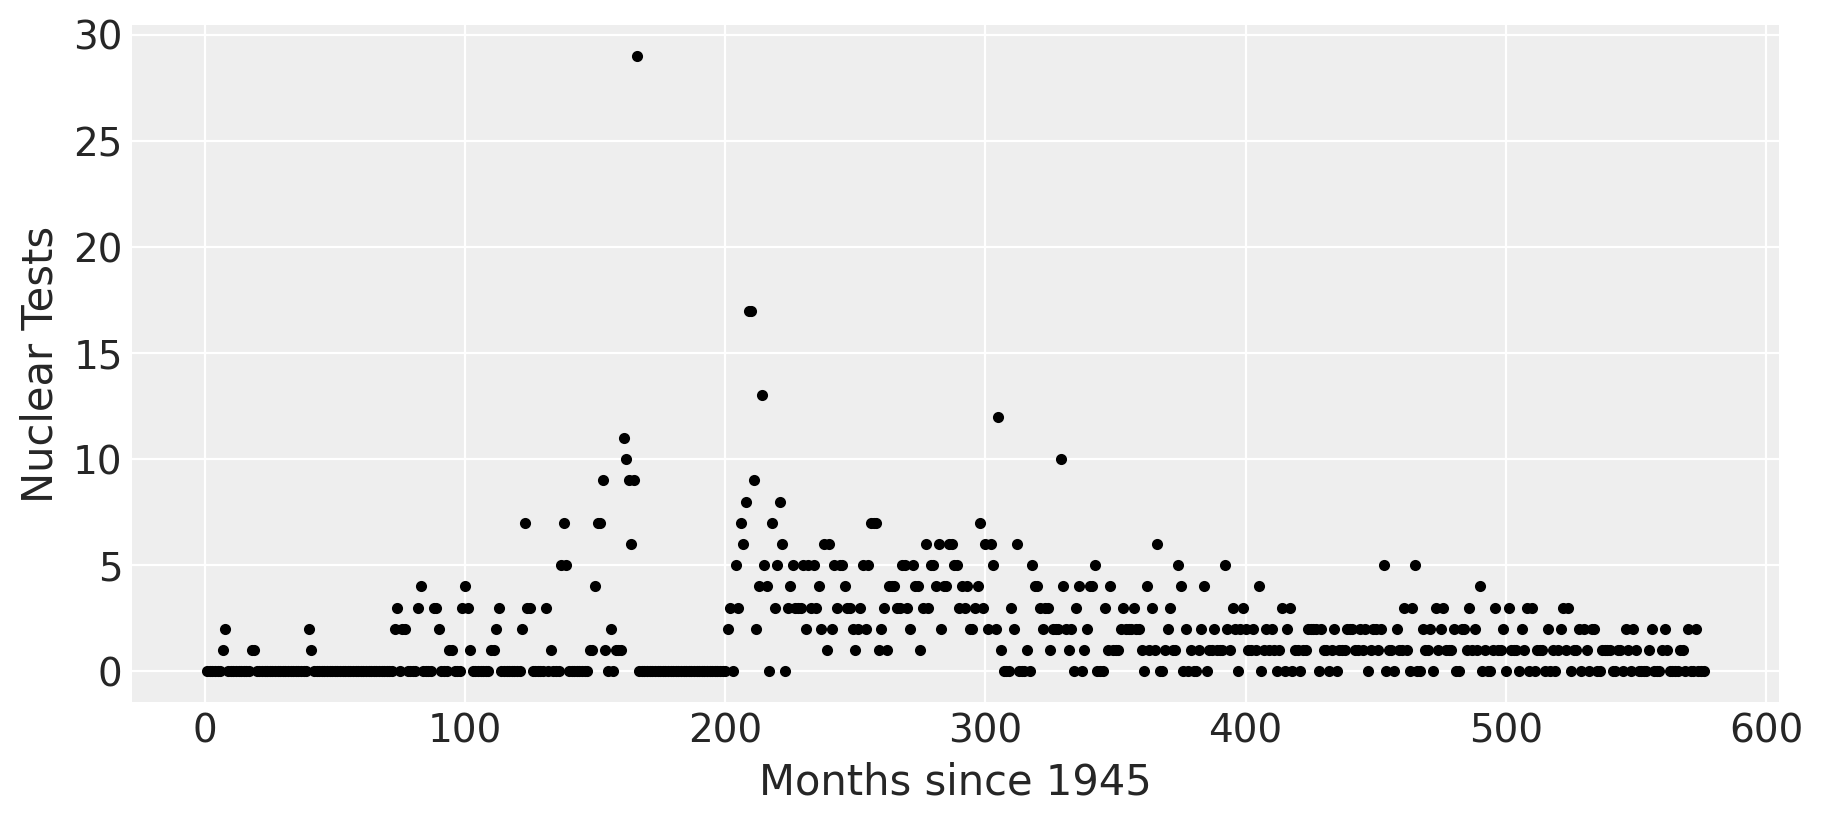

In [ ]:
fig = plt.figure(figsize=(9, 4))
ax = plt.gca()

ax.plot(frame.Ser_Month.values, frame.Tests.values, ".k")
ax.set_xlabel("Months since 1945")
ax.set_ylabel("Nuclear Tests");

array([[<Axes: title={'center': 'Tests'}>]], dtype=object)

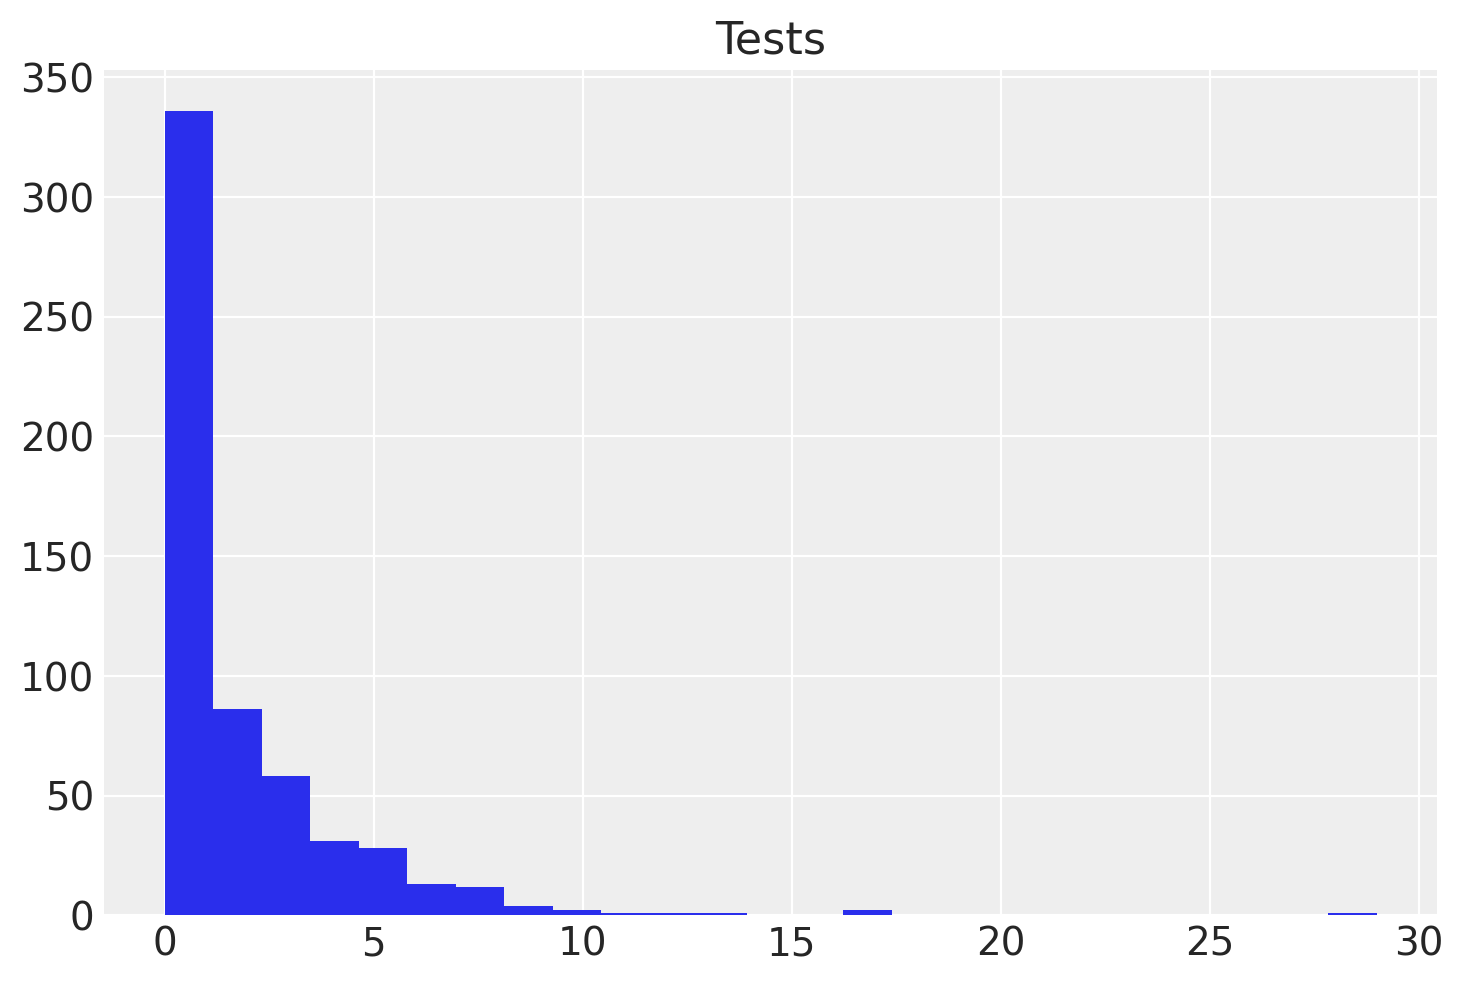

In [ ]:
frame.hist("Tests", bins = 25)

# Atmp 1

In [ ]:
year = frame.Year.values - 1945
serMonth = frame.Ser_Month.values
yrMonth = frame.Month.values

In [ ]:
y = frame.Tests.values

In [ ]:
coords = {
    "year": year,
    "time": serMonth,
    "month": yrMonth,
}

with pm.Model(coords = coords) as model_0:
    # global trend
    amplitude_trend = pm.HalfNormal(name="amplitude_trend", sigma=1.0)
    ls_trend = pm.Exponential(name="ls_trend", lam = 2)
    cov_trend = amplitude_trend * pm.gp.cov.ExpQuad(input_dim=1, ls=ls_trend)
    gp_trend = pm.gp.HSGP(m=[20], c=1.5, cov_func=cov_trend)
    f_trend = gp_trend.prior(name="f_trend", X=year[:, None], dims="year")

    # --- Parametrization ---
    mu = pm.Deterministic(
        name="mu",
        var=f_trend,
        dims="year",
    )

    # global noise
    sigma = pm.HalfNormal(name="sigma", sigma=2)

    # --- Likelihood ---
    pm.Normal(
        name="likelihood",
        mu=mu,
        sigma=sigma,
        observed=y,
        dims="year",
    )

    tr = pm.sample(target_accept=0.98, return_inferencedata=True)

Output()

In [ ]:
def MapYear(x):
  return 12*(x - 1945)
def DeMapYear(x):
  return x/12 + 1945

In [ ]:
tnew = np.linspace(0, MapYear(2000), 1000)
with model_0:
    #pri = gp.prior("pri", X=tnew[:, None])
    fnew = gp_trend.conditional("fnew", Xnew=tnew[:, None])

with model_0:
    ppc = pm.sample_posterior_predictive(tr, var_names=["fnew"])

Output()

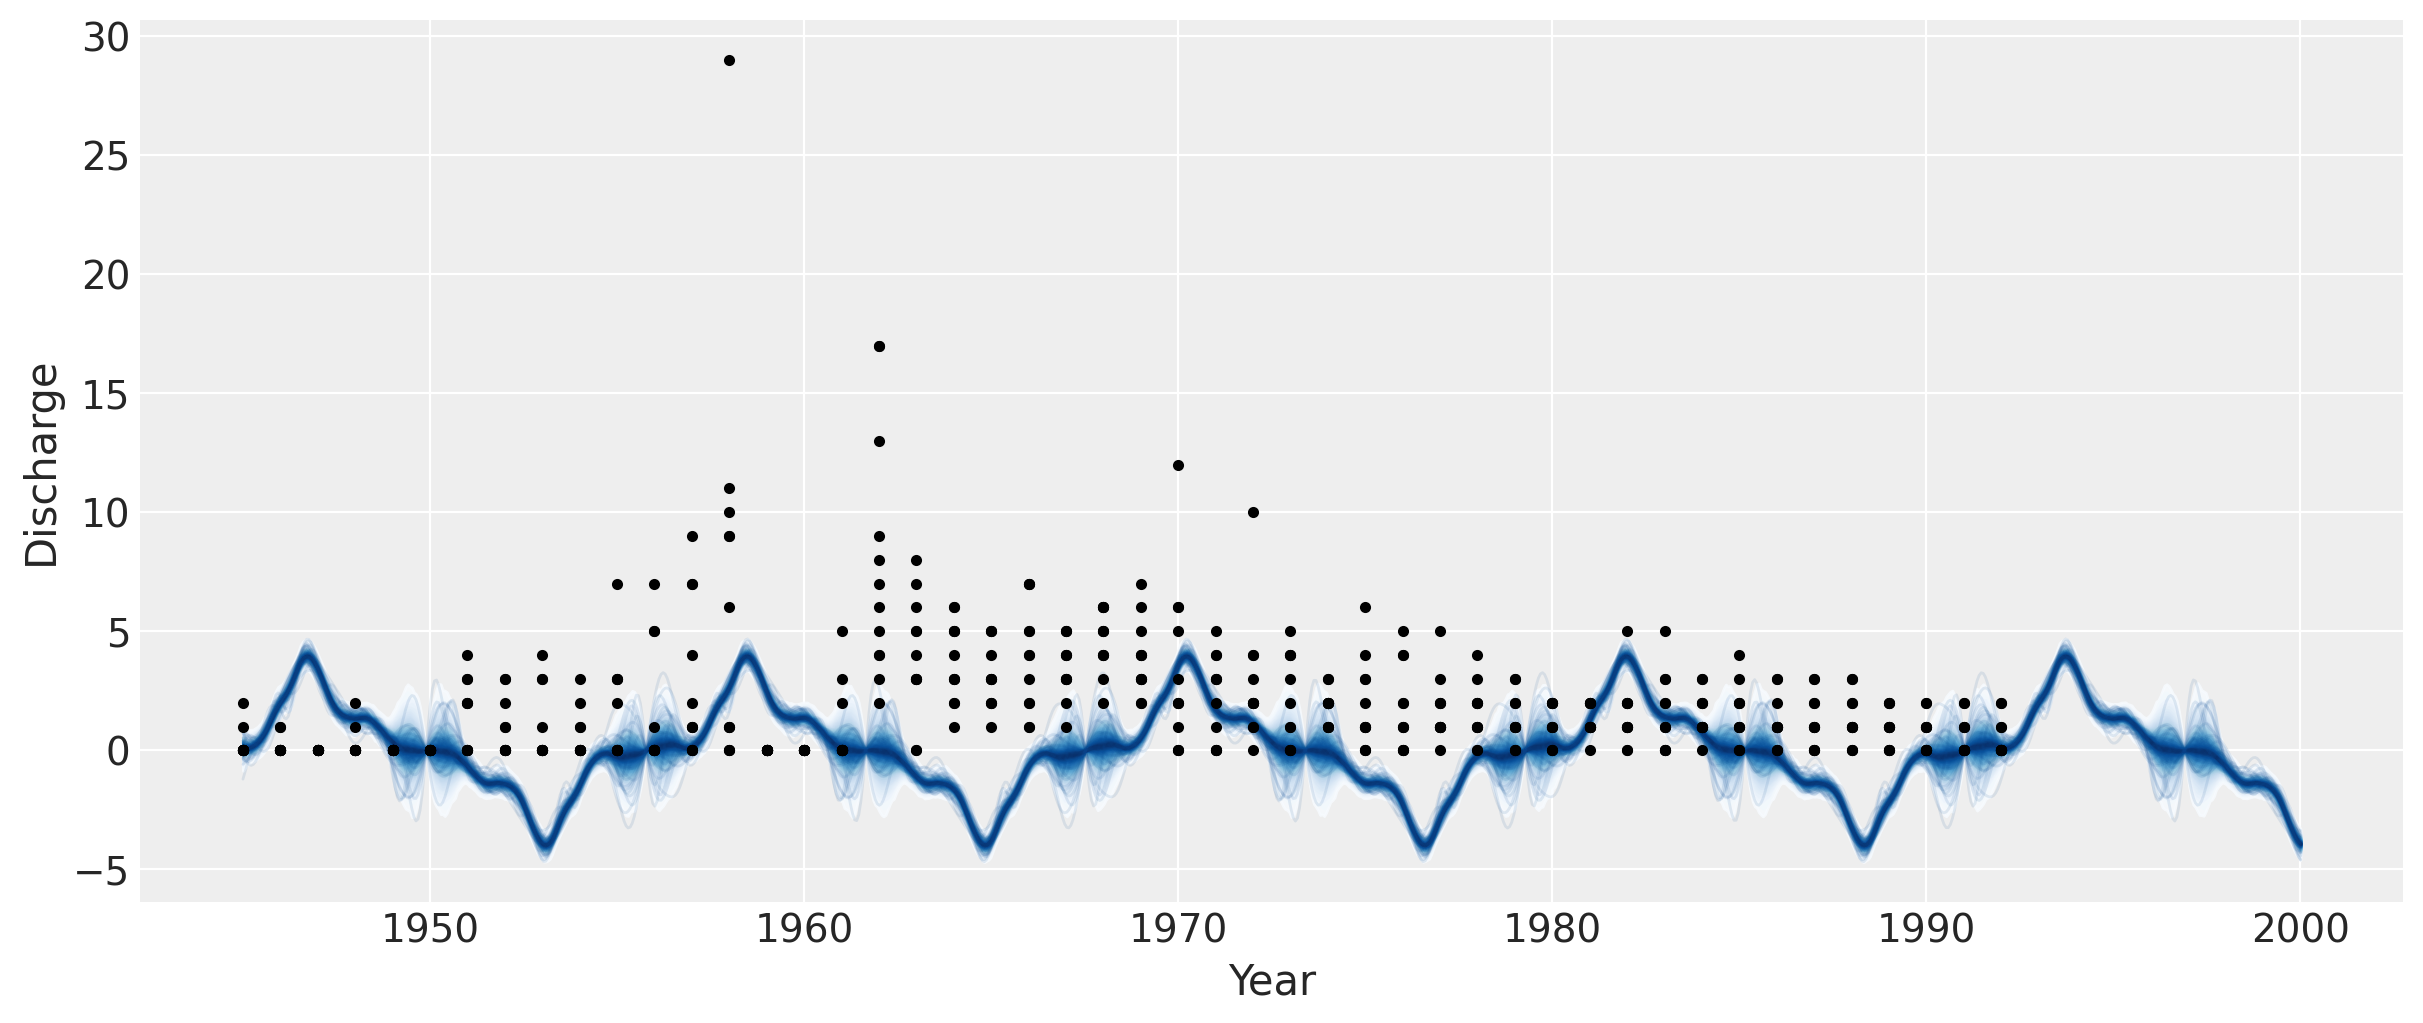

In [ ]:
samples = ppc.posterior_predictive["fnew"]

fig = plt.figure(figsize=(12, 5))
ax = plt.gca()
pm.gp.util.plot_gp_dist(ax, samples[0, :, :], DeMapYear(1*tnew), plot_samples=True, palette="Blues")
ax.plot(year+1945, y, "k.")
#ax.set_xlim([-100, 2000])
#ax.set_xlim([1910, 2030])
ax.set_ylabel("Discharge")
ax.set_xlabel("Year");